**In this notebook, I'll be tackling the Spaceship Titanic problem, which involves predicting which passengers were transported to an alternate dimension after the spaceship collided with a spacetime anomaly. The goal is to help rescue crews and retrieve the lost passengers, using records recovered from the spaceship's damaged computer system.**

# **<span style="color:#4B0082;">Library import, data reading and basic data information</span>**

In [68]:
import time
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from fancyimpute import KNN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from xgboost import XGBClassifier

In [69]:
import warnings
warnings.filterwarnings('ignore')

In [70]:
sns.set()
sns.set(rc = {'figure.figsize':(20,10)})
# sns.set_palette("PiYG")
sns.set_style("whitegrid")
colors = [matplotlib.colors.to_hex(sns.color_palette("PiYG")[0]), matplotlib.colors.to_hex(sns.color_palette("PiYG")[-1]), '#ffce30', '#990099', '#ff9900', '#0000ff']
my_palette = sns.color_palette(colors)
sns.set_palette(my_palette)
my_palette

[(0.8117647058823529, 0.2549019607843137, 0.5686274509803921),
 (0.3843137254901961, 0.6392156862745098, 0.1803921568627451),
 (1.0, 0.807843137254902, 0.18823529411764706),
 (0.6, 0.0, 0.6),
 (1.0, 0.6, 0.0),
 (0.0, 0.0, 1.0)]

In [71]:
train_data = pd.read_csv('input/train.csv')
train_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [72]:
test_data = pd.read_csv('input/test.csv')
test_data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [73]:
print('Shape of train set:', train_data.shape)
print('Shape of test set:', test_data.shape)

Shape of train set: (8693, 14)
Shape of test set: (4277, 13)


In [74]:
print(train_data.info())
train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [75]:
print(test_data.info())
test_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB
None


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,4186.000000,4195.000000,4171.000000,4179.000000,4176.000000,4197.000000
mean,28.658146,219.266269,439.484296,177.295525,303.052443,310.710031
std,14.179072,607.011289,1527.663045,560.821123,1117.186015,1246.994742
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,37.000000,53.000000,78.000000,33.000000,50.000000,36.000000
max,79.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000


Since both the training and test datasets contain passengers from the same ship, they come from the same distribution, so they can (and should) be processed as a whole.

In [76]:
train_data['train'] = True
test_data['train'] = False
data = pd.concat([train_data, test_data], ignore_index = True)
data

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,train
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,True
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,True
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12965,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter,NaN,False
12966,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron,NaN,False
12967,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore,NaN,False
12968,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale,NaN,False


# **<span style="color:#4B0082;">Exploratory data analysis</span>**

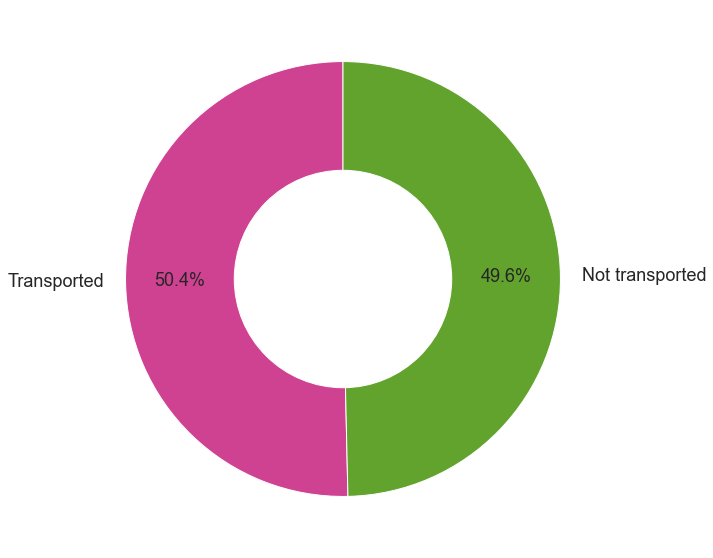

In [77]:
labels = ['Transported', 'Not transported']
sizes = [data[data['Transported'] == True].shape[0], data[data['Transported'] == False].shape[0]]

plt.pie(sizes, colors = my_palette, labels = labels, autopct = '%1.1f%%', pctdistance = 0.75, startangle = 90, textprops = {'fontsize': 18})
plt.gca().add_artist(plt.Circle((0,0), 0.5, fc='white'))
plt.rcParams.update({'font.size': 25});

The target variable is perfectly balanced, which is good.

Firstly, let's extract some information from PassengerId, Name and Cabin columns.\
From the description of data, we know, that:
- **PassengerId** contains a group the passenger is travelling with and their number within the group. I will not extract number within in group.
- **Name** contains the first and last names of the passenger. We will extract only Last Name.
- **Cabin** contains deck/num/side.

In [78]:
data['Group_number'] = data['PassengerId'].str.split('_').str[0].astype(int)

data.loc[data['Name'].notna(), 'Last_name'] = data.loc[data['Name'].notna(), 'Name'].str.split().str[-1]

data.loc[data['Cabin'].notna(), 'Cabin_deck'] = data.loc[data['Cabin'].notna(), 'Cabin'].str.split('/').str[0]
data.loc[data['Cabin'].notna(), 'Cabin_number'] = data.loc[data['Cabin'].notna(), 'Cabin'].str.split('/').str[1].astype(int)
data.loc[data['Cabin'].notna(), 'Cabin_side'] = data.loc[data['Cabin'].notna(), 'Cabin'].str.split('/').str[-1]

data.drop(columns = ['Cabin', 'Name'], inplace=True)
data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,train,Group_number,Last_name,Cabin_deck,Cabin_number,Cabin_side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,True,1,Ofracculy,B,0.0,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,True,2,Vines,F,0.0,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,True,3,Susent,A,0.0,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,True,3,Susent,A,0.0,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,True,4,Santantines,F,1.0,S


Now let's again take a look at types of columns.

In [79]:
data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported      object
train              bool
Group_number      int32
Last_name        object
Cabin_deck       object
Cabin_number    float64
Cabin_side       object
dtype: object

We have numerical: Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck, Group, Cabin_number.
And categorical: HomePlanet, CryoSleep, Destination, VIP, Last_nme, Cabin_deck, Cabin_side.

Let's look at the dependence of the target variable on numerical features.
And also I will make new column Total_spends, which will be the sum of all features showing costs.

In [80]:
def make_total_spends_column(df):
    df['Total_spends'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck']
    return df

data = make_total_spends_column(data)

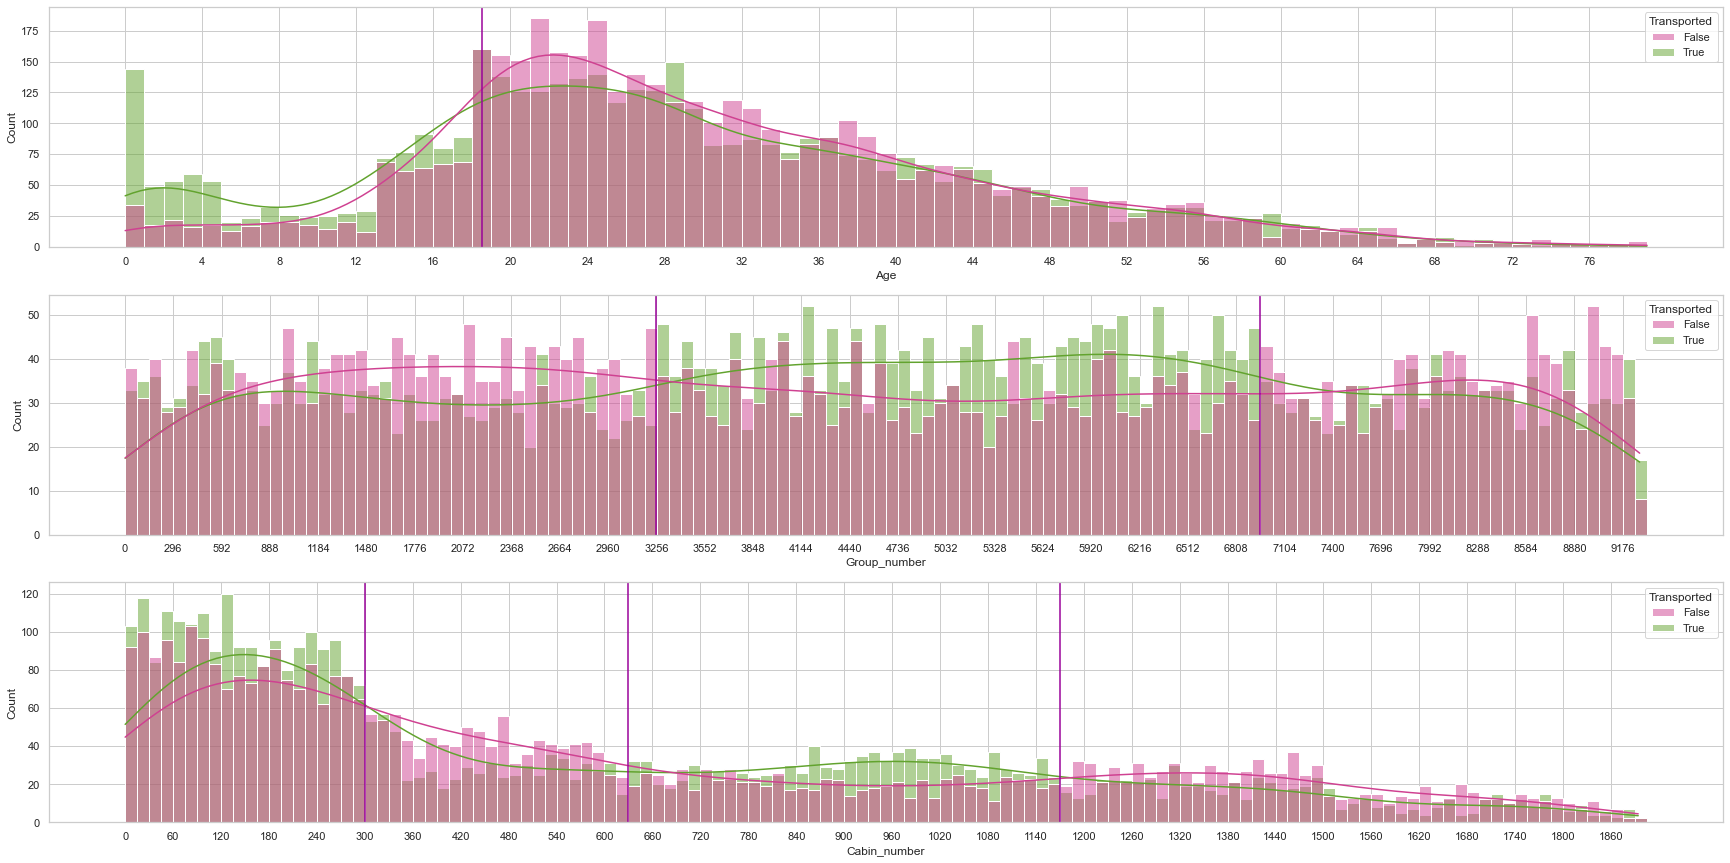

In [81]:
fig, axis = plt.subplots(3, 1, figsize=(30, 15))

columns = ['Age', 'Group_number', 'Cabin_number']
binwidths = [1, int((data['Group_number'].max() - data['Group_number'].min()) / 125), int((data['Cabin_number'].max() - data['Cabin_number'].min()) / 125)]
lines = [[18.5], [3256, 6956], [300, 630, 1170]]

for column, binwidth, ax, line in zip(columns, binwidths, axis.flat, lines):
    sns.histplot(data = data, x = column, hue = "Transported", kde = True, binwidth = binwidth, palette = my_palette, ax = ax)
    ax.set_xticks(range(0, int(data[column].max()) + 1, binwidth * 4))
    for l in line:
        ax.axvline(l, color = colors[3])
sns.set_style("whitegrid");

Insights:
- Childs (passengers under 18) were more often transported. And passengers above 18 were more often not transported. Later we will see what groups can be made: under 18 and over, or under 19 and over.
- I see three groups in Group_number: < 3256, 3256-6956, 6956 <.
- Several groups in Cabin_number:  < 300, 300-630, 630-1170, 1170 <.

In [82]:
def make_groups_by_group_number(df):
    df.loc[(df['Group_number'] <= 3256), 'Group_by_group_number'] = 0
    df.loc[(df['Group_number'] > 3256) & (df['Group_number'] <= 6956), 'Group_by_group_number'] = 1
    df.loc[(df['Group_number'] > 6956), 'Group_by_group_number'] = 2
    return df


data = make_groups_by_group_number(data)

In [83]:
def make_groups_by_cabin_number(df):
    df.loc[(df['Cabin_number'] <= 300), 'Group_by_cabin_number'] = 0
    df.loc[(df['Cabin_number'] > 300) & (df['Cabin_number'] <= 630), 'Group_by_cabin_number'] = 1
    df.loc[(df['Cabin_number'] > 630) & (df['Cabin_number'] <= 1170), 'Group_by_cabin_number'] = 2
    df.loc[(df['Cabin_number'] > 1170), 'Group_by_cabin_number'] = 3
    return df

data = make_groups_by_cabin_number(data)

We will not look at the same charts of features indicating spending, because they all look like an exponential distribution, therefore we cannot make any conclusions from them.:

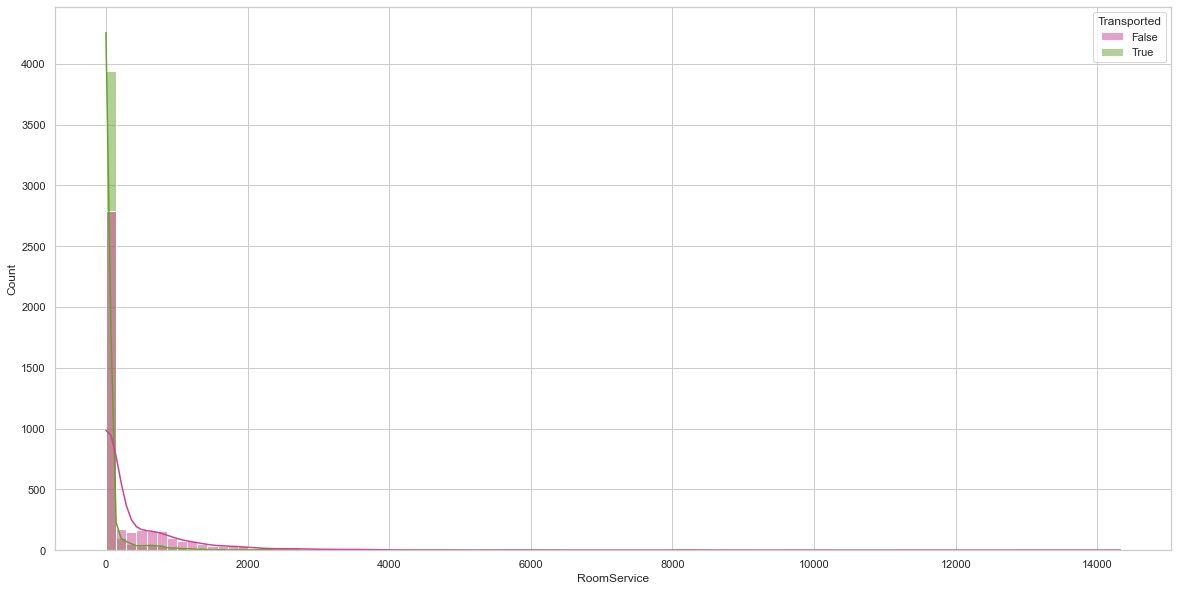

In [84]:
sns.histplot(data = data, x = 'RoomService', hue = "Transported", bins = 100, kde = True, palette = my_palette)
sns.set_style("whitegrid");

Let's look at the boxplots:

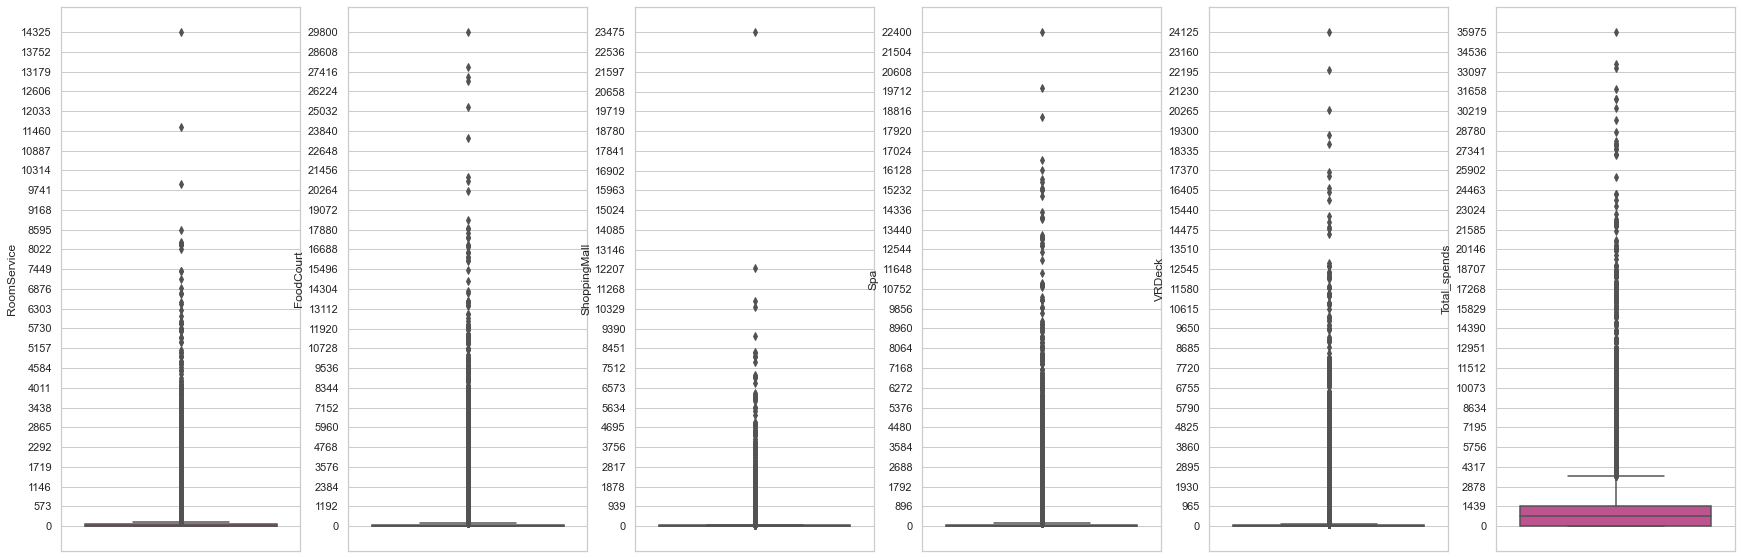

In [85]:
fig, axis = plt.subplots(1, 6, figsize=(30, 10))

columns =  ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total_spends']

for column, ax in zip(columns, axis.flat):
    sns.boxplot(data = data, y = column, ax = ax, palette = my_palette)
    ax.set_yticks(range(0, int(data[column].max()) + 1, int((data[column].max() - data[column].min()) / 25)))
sns.set_style("whitegrid");

The 50% quantile is zero everywhere (except for Total_spends). I will make features 'name_of_cost_feature_zero' for indicate whether the passenger spent money at all.

In [86]:
def make_zero_columns(df):
    for column in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total_spends']:
        zero_column = column + '_zero'
        df.loc[df[column] == 0, zero_column] = True
        df.loc[df[column] > 0, zero_column] = False
    return df

data = make_zero_columns(data)

Now let's take a look on dependency between features.

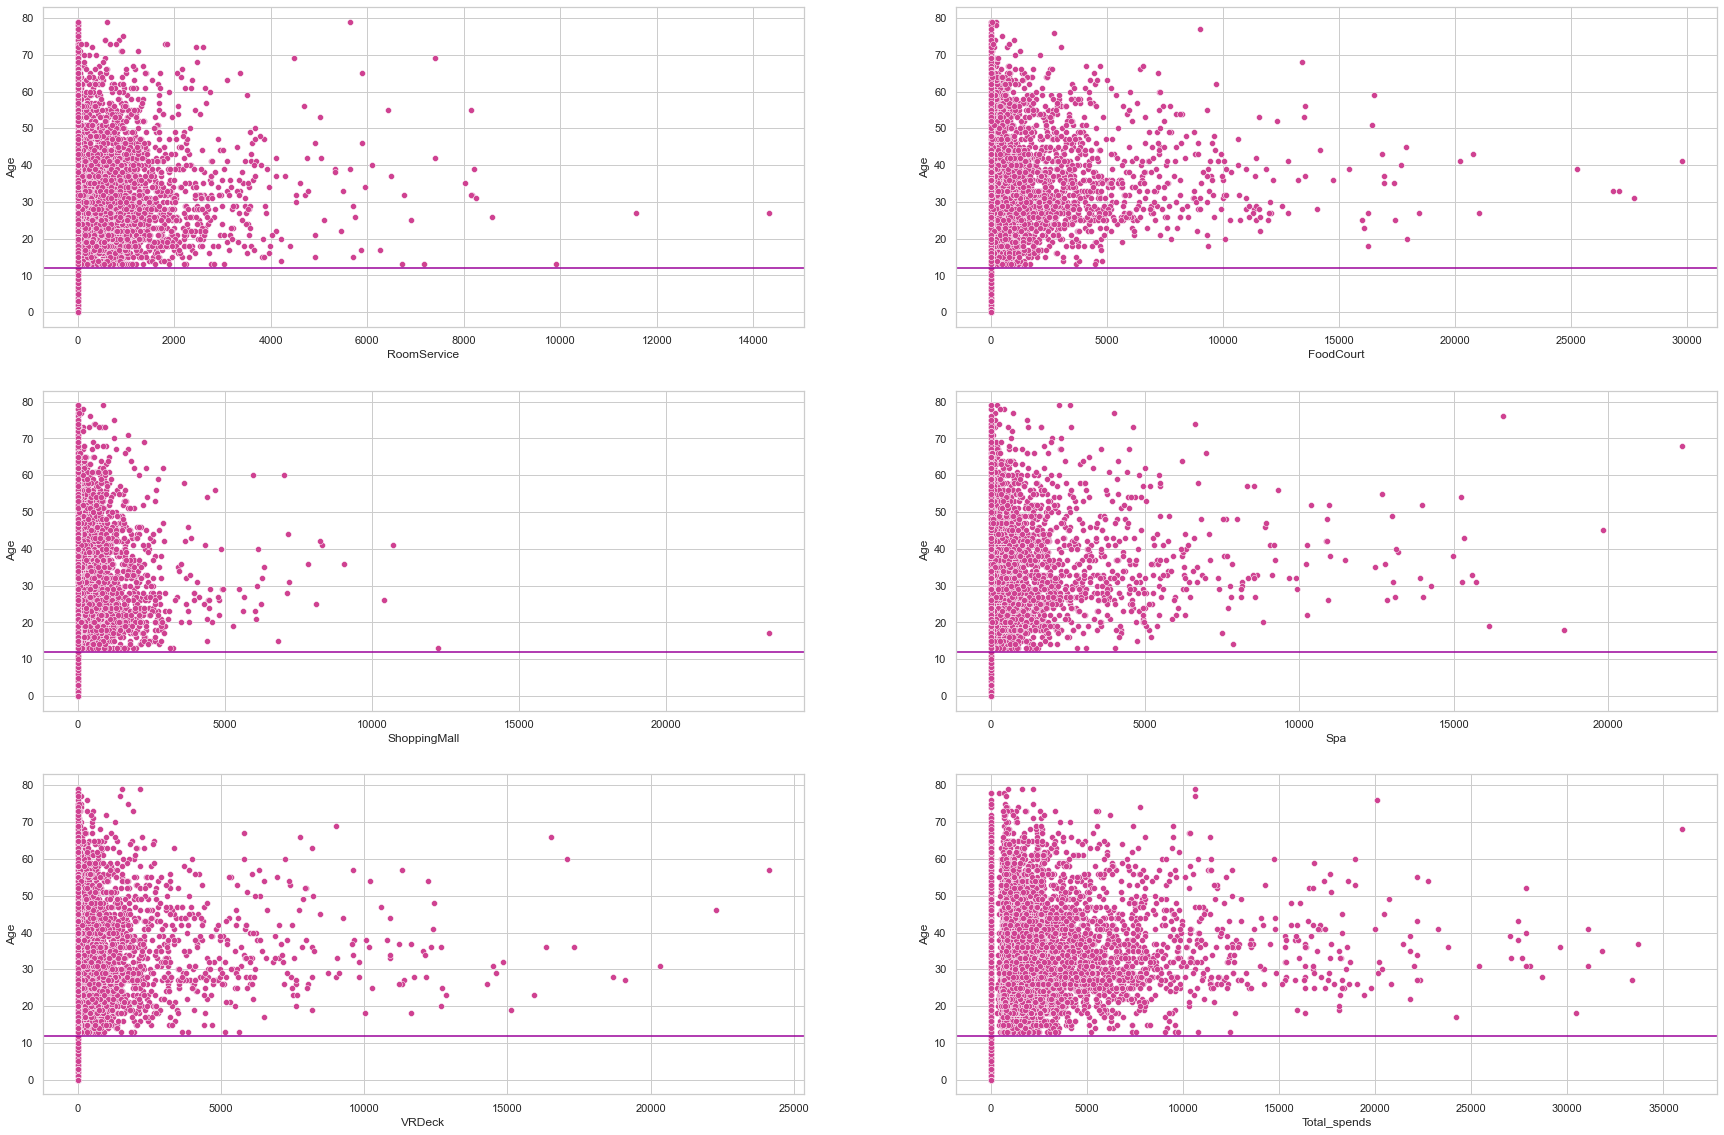

In [87]:
columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total_spends']

sns.set_palette(my_palette)

fig, axis = plt.subplots(3, 2, figsize=(30,20))

for column, ax in zip(columns, axis.flat):
    sns.scatterplot(data, y = 'Age', x = column, ax = ax, palette = my_palette)
    ax.axhline(12, color = colors[3])

sns.set_palette(my_palette)
sns.set_style("whitegrid");

Insights:
- Passengers of 12 years old and under doesn't spend money.

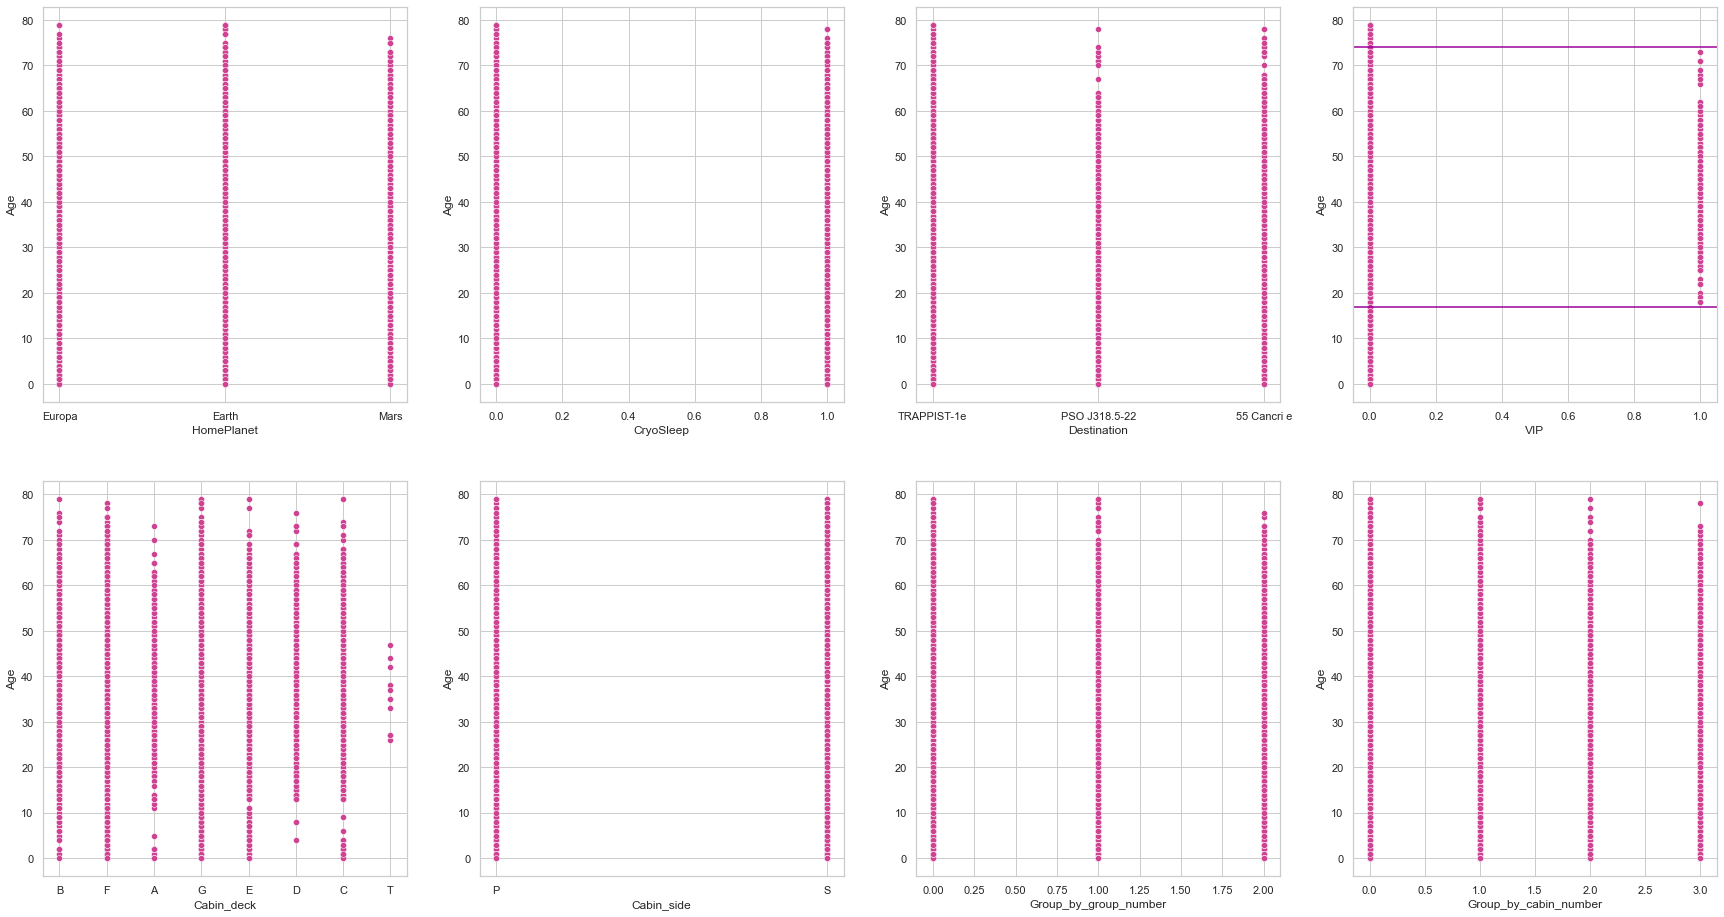

In [88]:
columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_deck', 'Cabin_side', 'Group_by_group_number', 'Group_by_cabin_number']

fig, axis = plt.subplots(2, 4, figsize=(30,16))

for column, ax in zip(columns, axis.flat):
    sns.scatterplot(data, y = 'Age', x = column, ax = ax, palette = my_palette)
    if column == 'VIP':
        ax.axhline(17, color = colors[3])
        ax.axhline(74, color = colors[3])

sns.set_style("whitegrid");


In [89]:
data[data['Age'] < 17].shape[0]

2022

In [90]:
data[data['Age'] >= 74].shape[0]

27

Insights:
- Passengers under 18 yo didn't have VIP. And the older 73 yo passengers too - but there are too few of them, we cannot make any conclusions about them, because they can all be a coincidence.

Let's make groups based on age insights:

In [91]:
def make_age_groups(df):
    df.loc[df['Age'] < 13, 'Age_group'] = 0
    df.loc[(df['Age'] >= 13) & ((df['Age'] < 18)), 'Age_group'] = 1
    df.loc[(df['Age'] >= 18), 'Age_group'] = 2
    return df

data = make_age_groups(data)

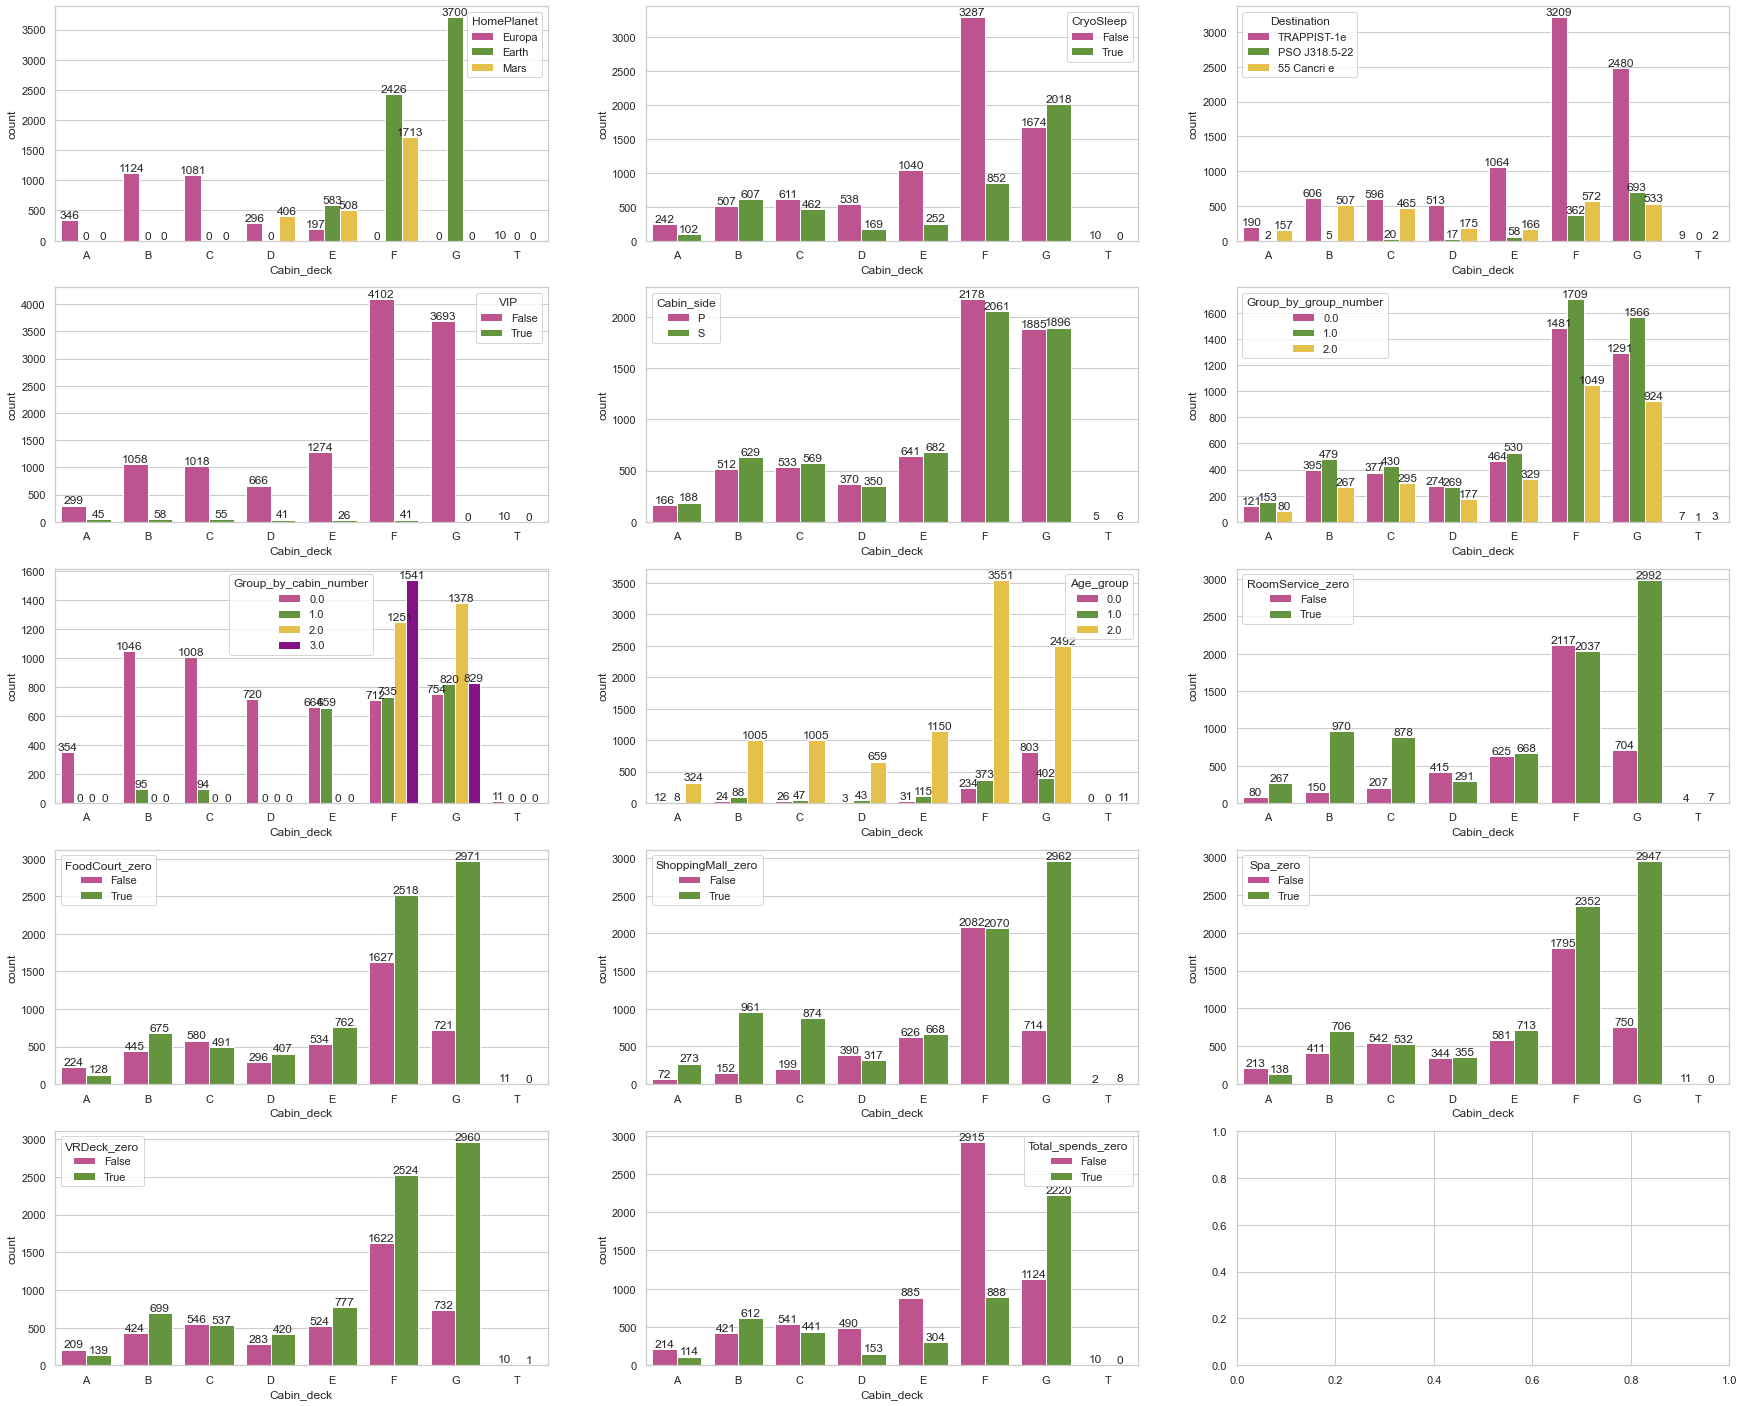

In [92]:
columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_deck', 'Cabin_side', 'Group_by_group_number', 'Group_by_cabin_number', 'Age_group', 'RoomService_zero', 'FoodCourt_zero', 'ShoppingMall_zero', 'Spa_zero', 'VRDeck_zero', 'Total_spends_zero']

main_column = 'Cabin_deck'
columns = [column for column in columns if column != main_column]

order = list(data[main_column][data[main_column].notna()].unique())
order.sort()

fig, axis = plt.subplots(5, 3, figsize=(30, 25))

for column, ax in zip(columns, axis.flat):
    sns.countplot(data = data, x = main_column, hue = column, ax = ax, palette = my_palette, order = order)
    for container in ax.containers:
        ax.bar_label(container, fontsize = 12)

sns.set_style("whitegrid");

Insights:
- All passengers from Cabin Decks A, B and C was from Europa.
- All passengers from Cabin Deck G was from Earth.
- No one from Cabin Deck D was from Earth.
- No one from Cabin Deck F was from Europa.
- No one from Cabin Deck G had a VIP.
- All passengers from Cabin Decks A and D was in Group_by_cabin_number 0.
- No one from Cabin Decks B, C and E was from Group_by_cabin_number 2 or 3.
- ~~We can't make any conclusions about Cabin Deck T - it's too small.~~

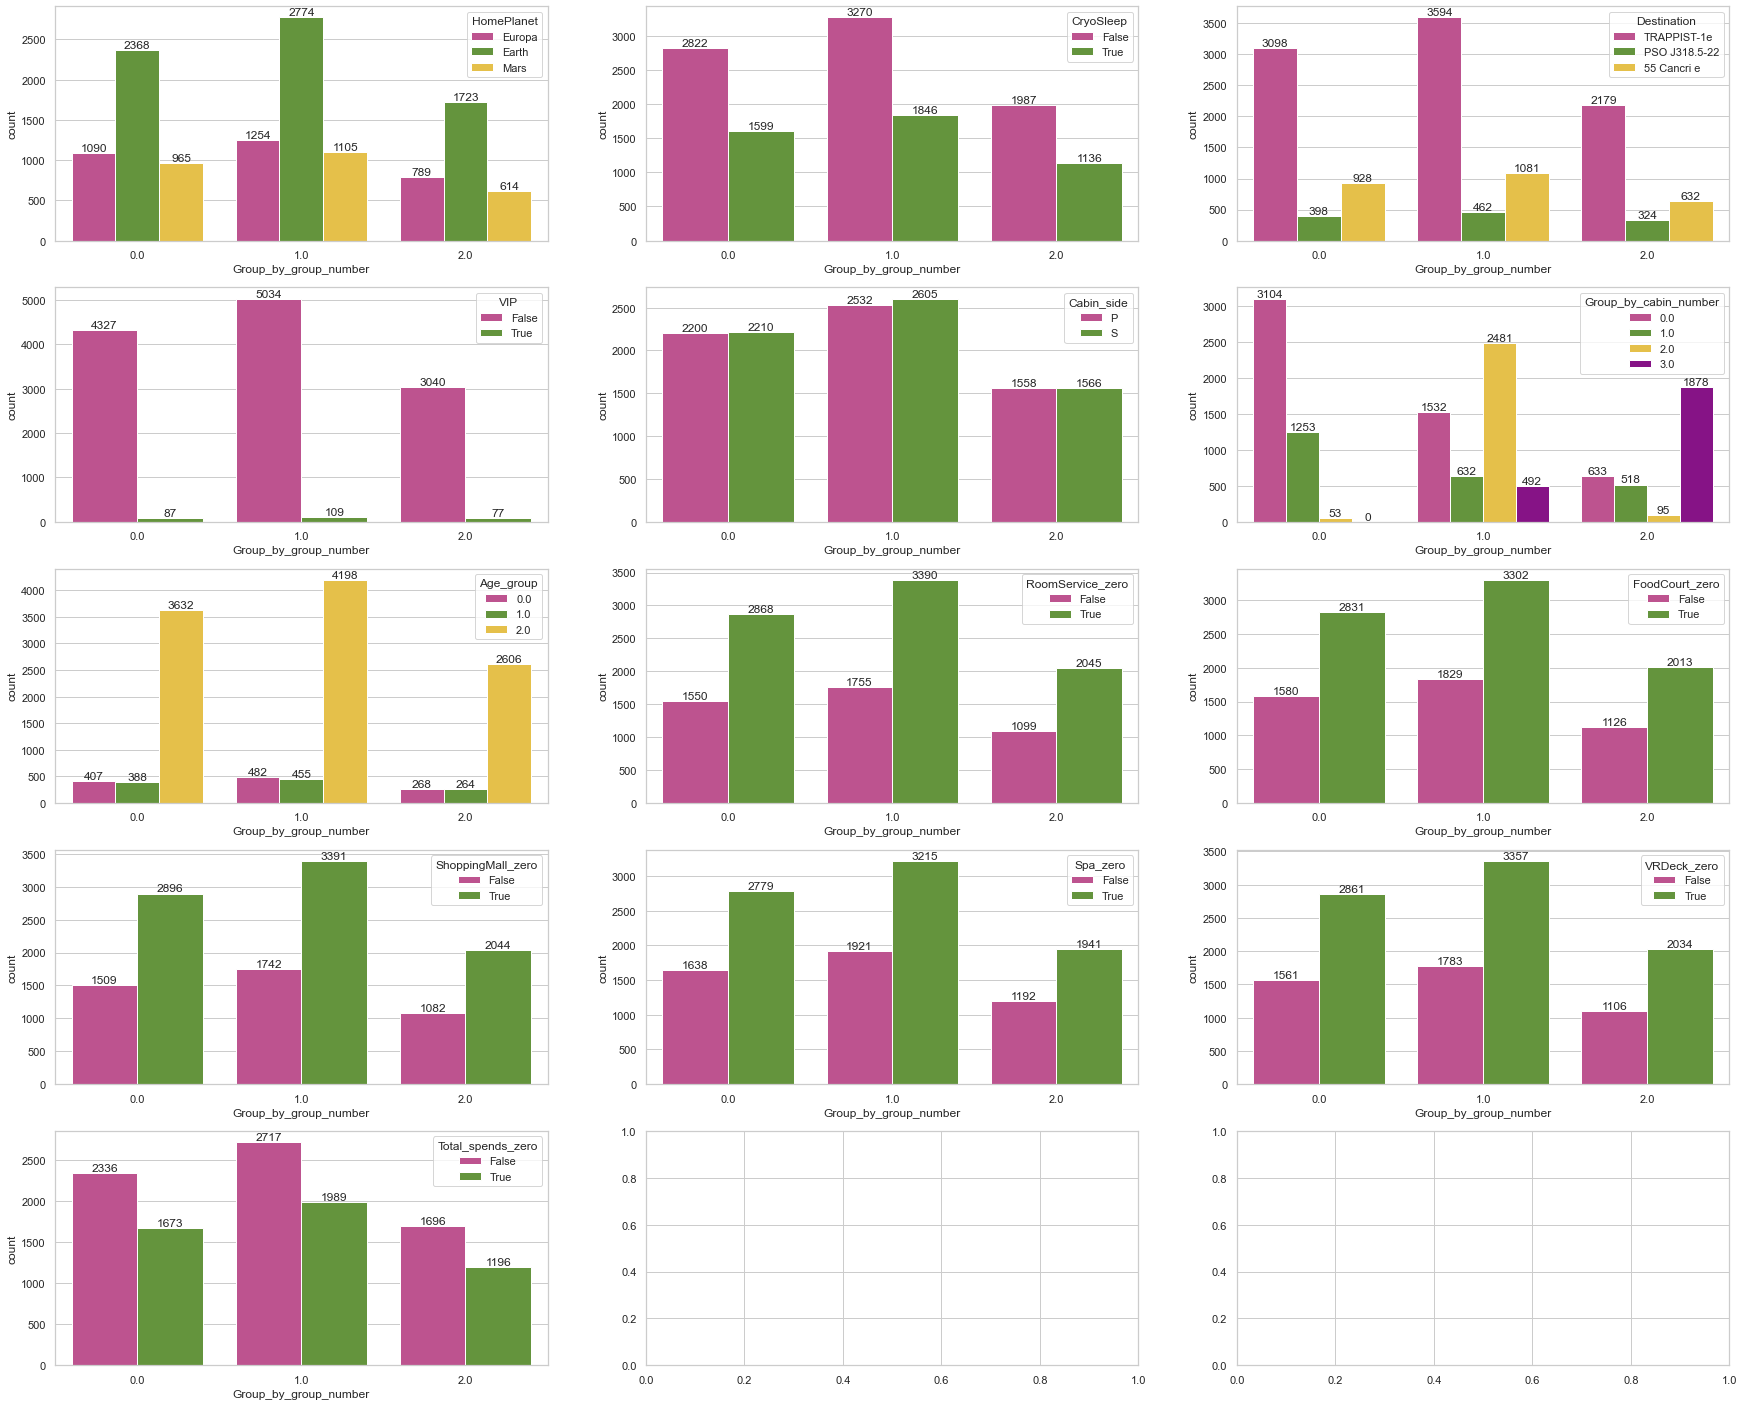

In [93]:
main_column = 'Group_by_group_number'
columns = [column for column in columns if column != main_column]

order = list(data[main_column][data[main_column].notna()].unique())
order.sort()

fig, axis = plt.subplots(5, 3, figsize=(30, 25))

for column, ax in zip(columns, axis.flat):
    sns.countplot(data = data, x = main_column, hue = column, ax = ax, palette = my_palette, order = order)
    for container in ax.containers:
        ax.bar_label(container, fontsize = 12)

sns.set_style("whitegrid");

Insights:
- No one from Group_by_group_number 0 was in Group_by_cabin_number 3.

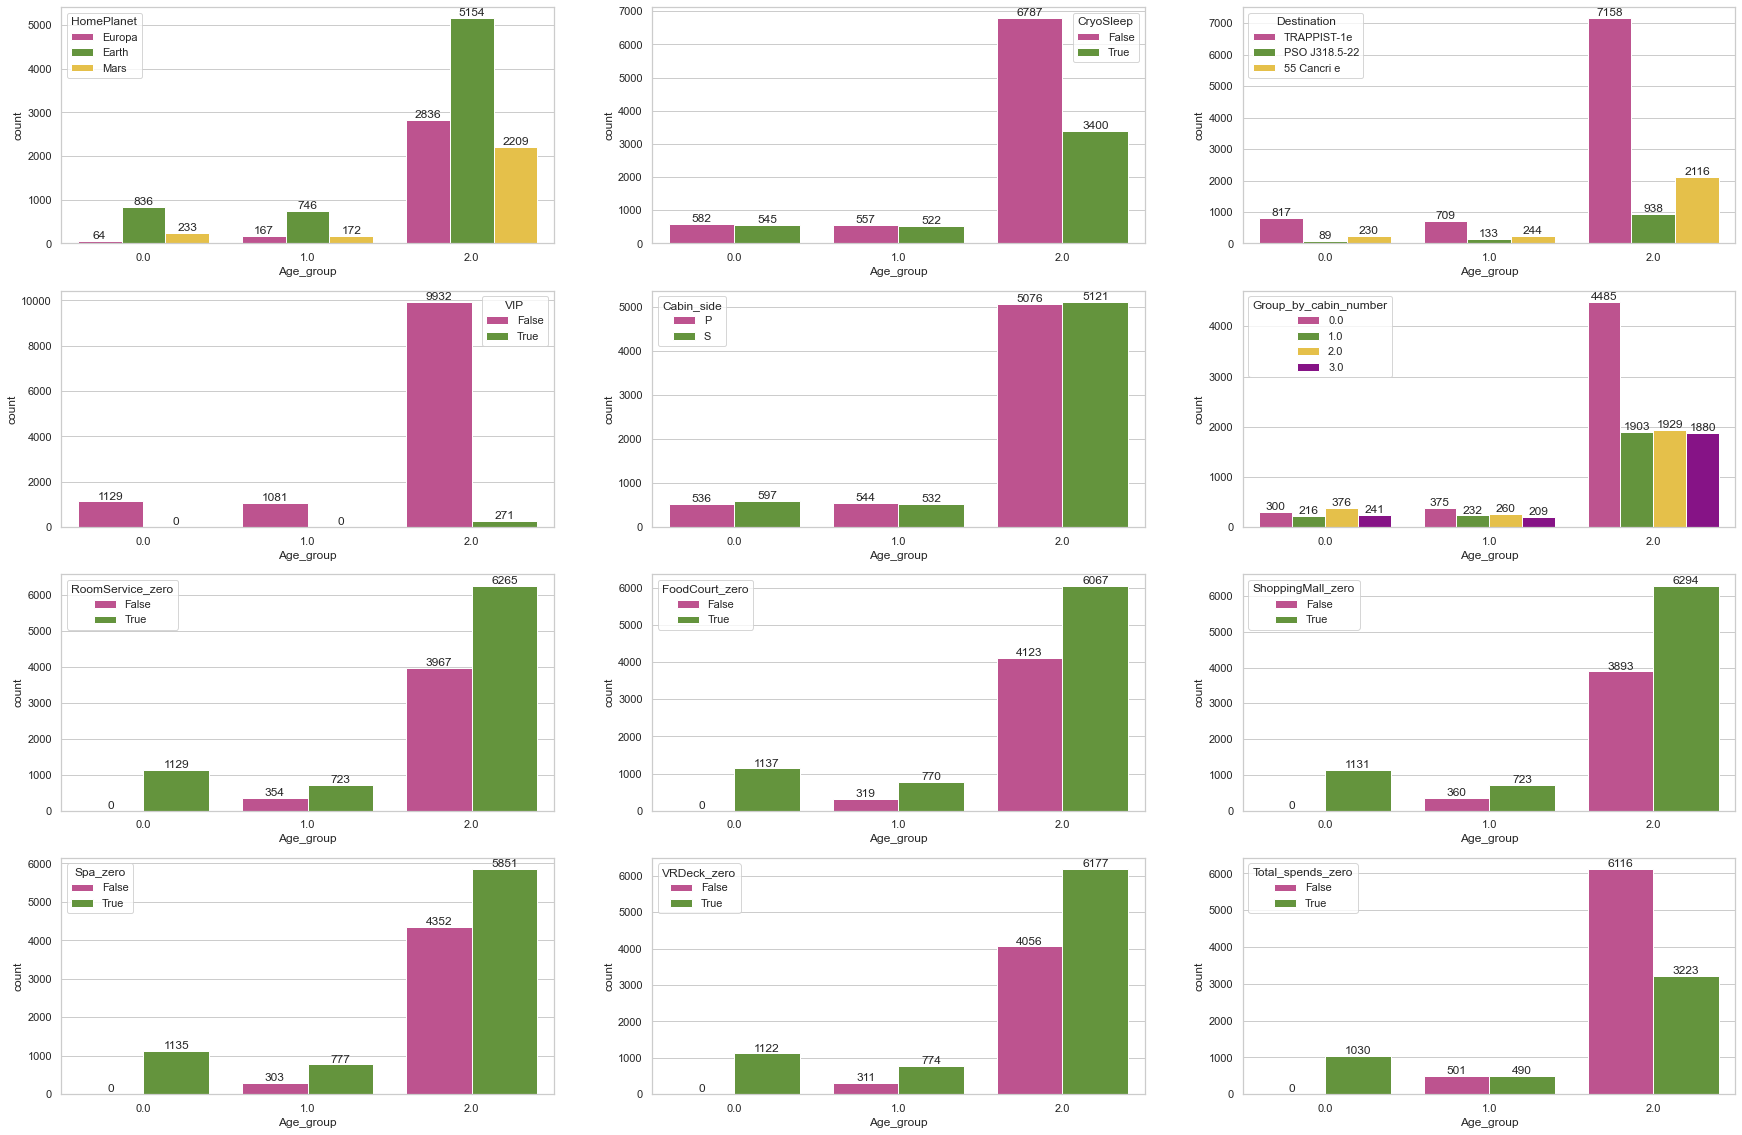

In [94]:
main_column = 'Age_group'
columns = [column for column in columns if column != main_column]

order = list(data[main_column][data[main_column].notna()].unique())
order.sort()

fig, axis = plt.subplots(4, 3, figsize=(30, 20))

for column, ax in zip(columns, axis.flat):
    sns.countplot(data = data, x = main_column, hue = column, ax = ax, palette = my_palette, order = order)
    for container in ax.containers:
        ax.bar_label(container, fontsize = 12)

sns.set_style("whitegrid");

Insights:
- No one from Age_group 0 and 1 had a VIP.

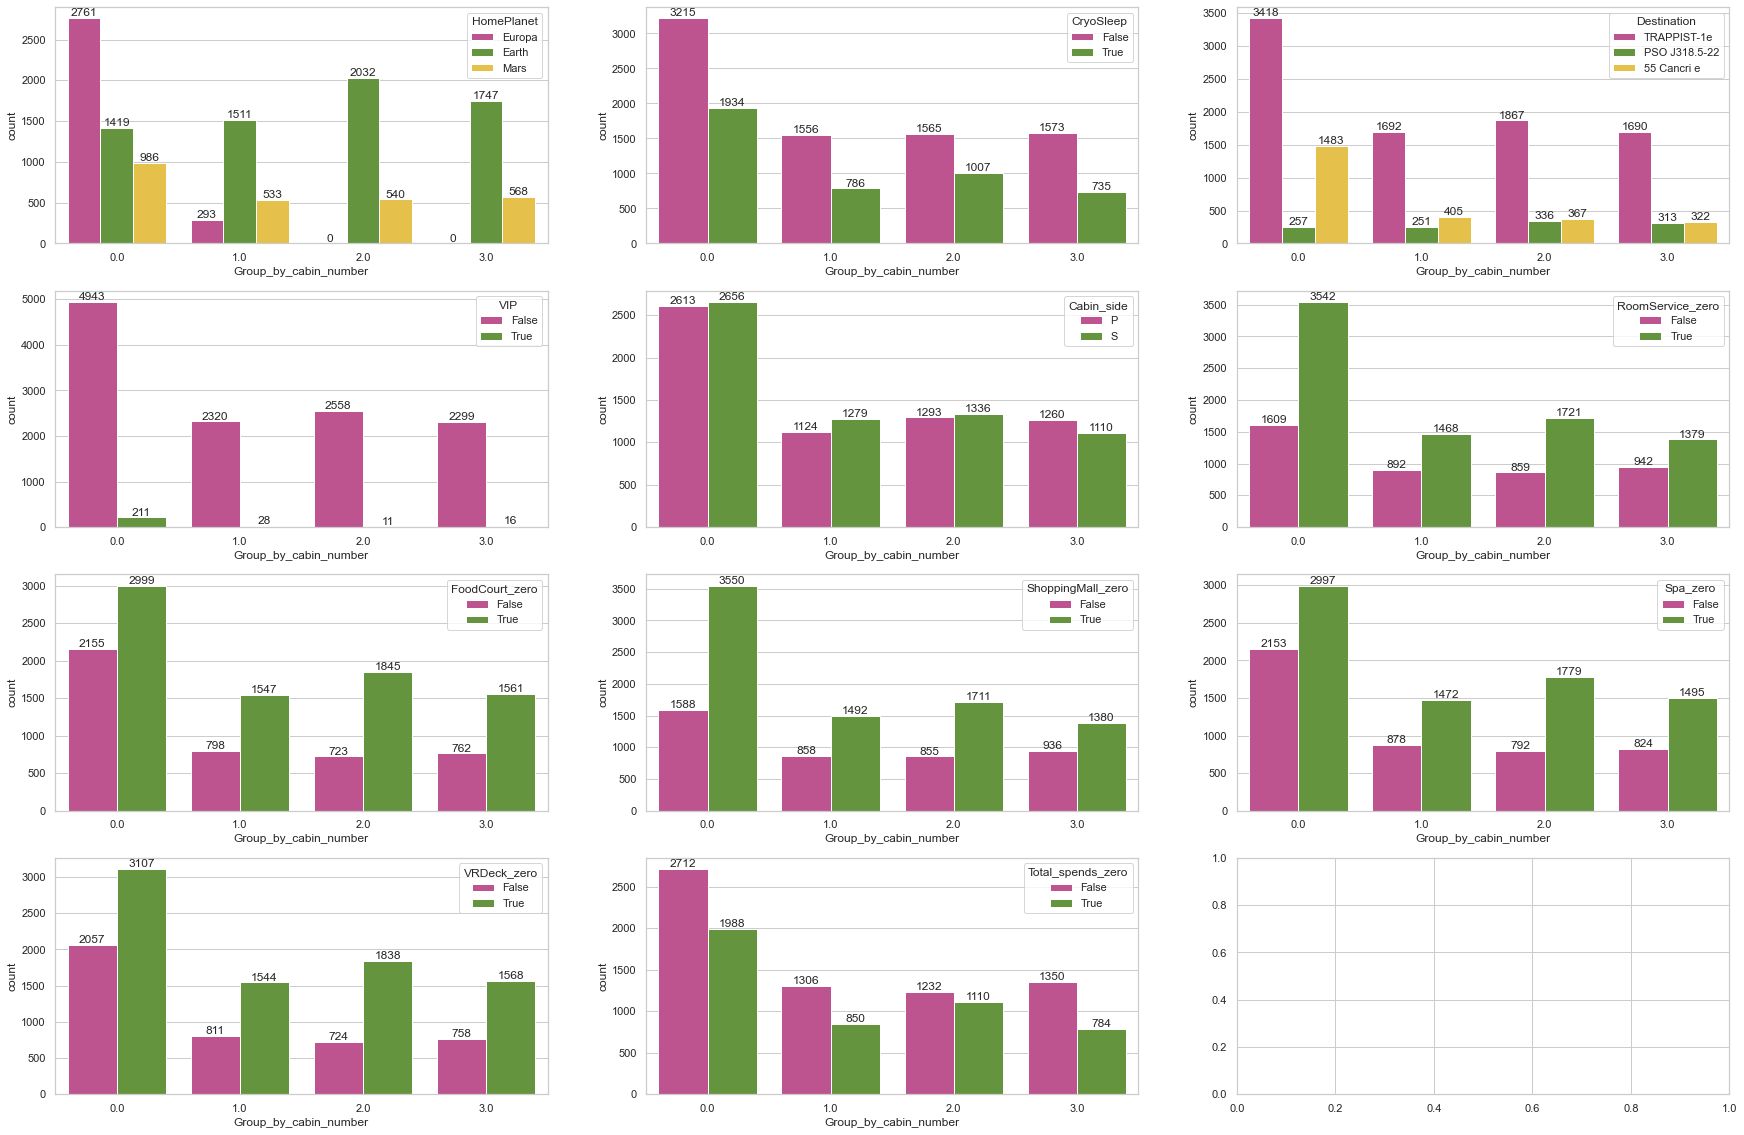

In [95]:
main_column = 'Group_by_cabin_number'
columns = [column for column in columns if column != main_column]

order = list(data[main_column][data[main_column].notna()].unique())
order.sort()

fig, axis = plt.subplots(4, 3, figsize=(30, 20))

for column, ax in zip(columns, axis.flat):
    sns.countplot(data = data, x = main_column, hue = column, ax = ax, palette = my_palette, order = order)
    for container in ax.containers:
        ax.bar_label(container, fontsize = 12)

sns.set_style("whitegrid");

Insights:
- No one from Group_by_cabin_number 2 and 3 was from Europa.

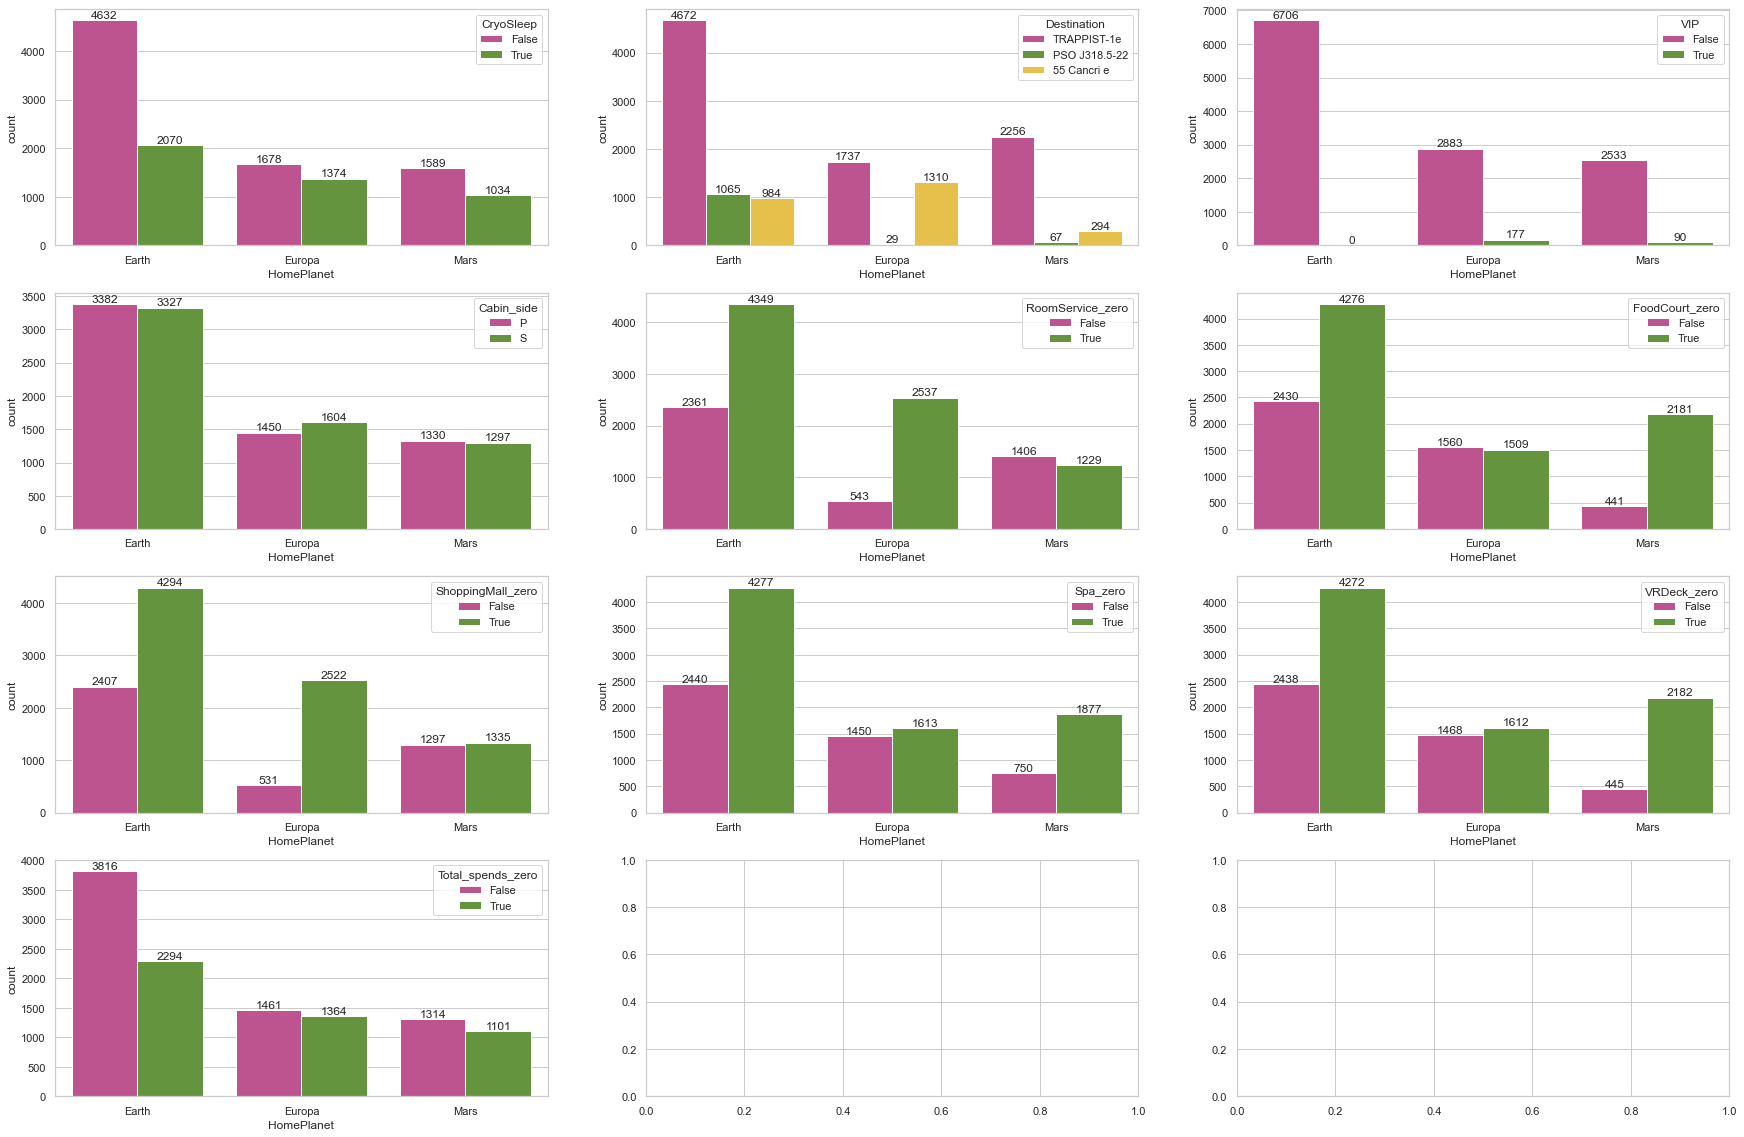

In [96]:
main_column = 'HomePlanet'
columns = [column for column in columns if column != main_column]

order = list(data[main_column][data[main_column].notna()].unique())
order.sort()

fig, axis = plt.subplots(4, 3, figsize=(30, 20))

for column, ax in zip(columns, axis.flat):
    sns.countplot(data = data, x = main_column, hue = column, ax = ax, palette = my_palette, order = order)
    for container in ax.containers:
        ax.bar_label(container, fontsize = 12)

sns.set_style("whitegrid");

Insights:
- No one from Earth had a VIP.

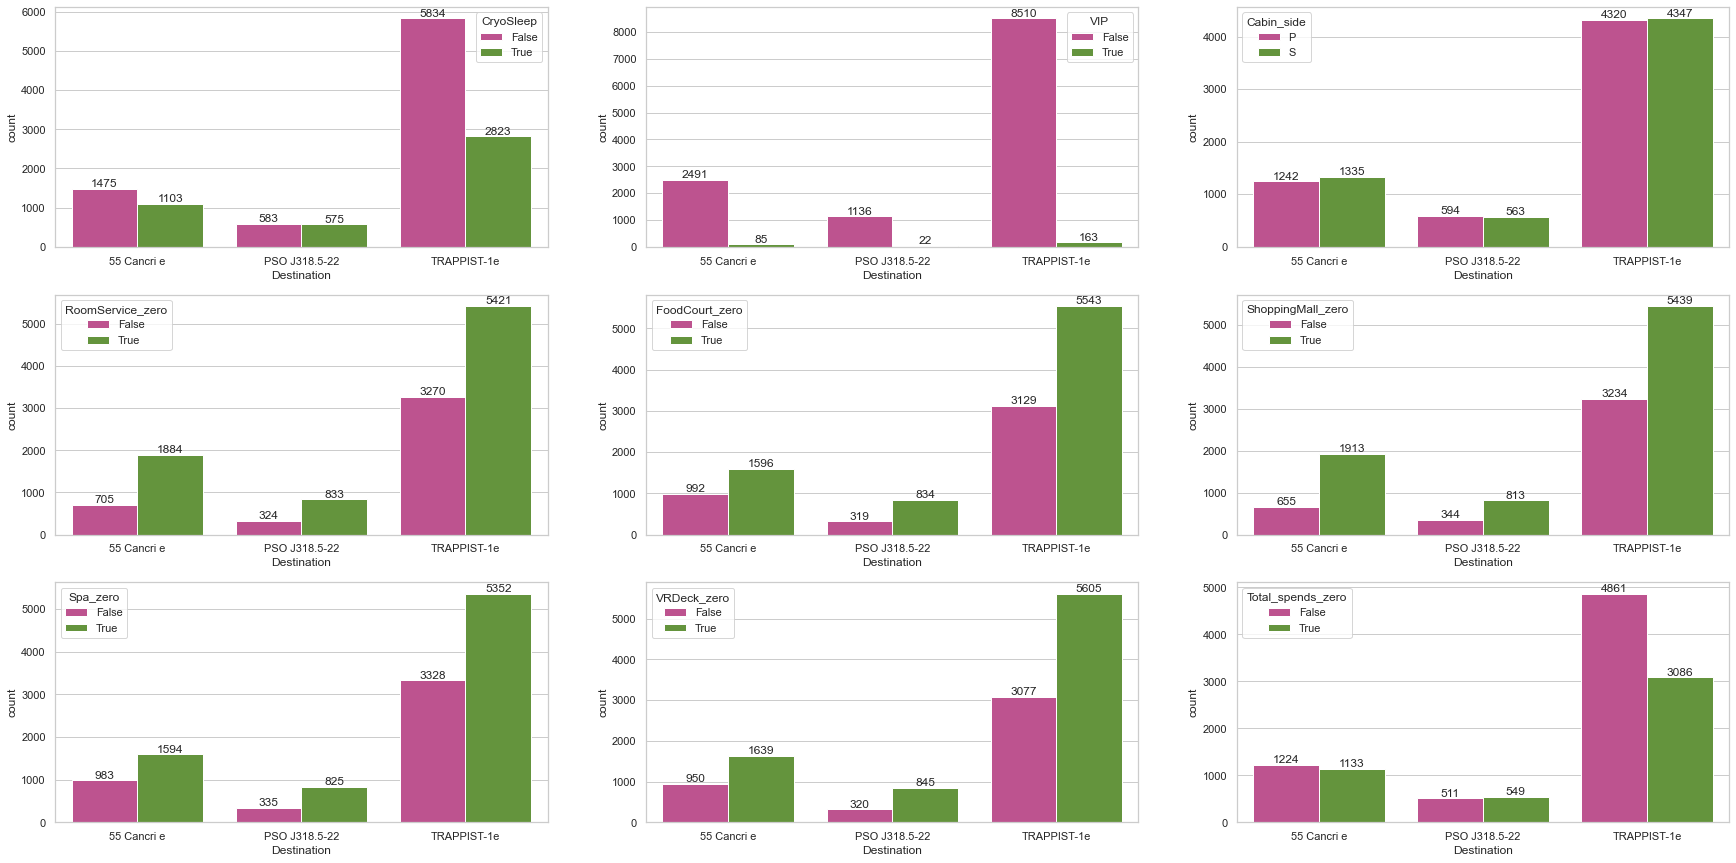

In [97]:
main_column = 'Destination'
columns = [column for column in columns if column != main_column]

order = list(data[main_column][data[main_column].notna()].unique())
order.sort()

fig, axis = plt.subplots(3, 3, figsize=(30, 15))

for column, ax in zip(columns, axis.flat):
    sns.countplot(data = data, x = main_column, hue = column, ax = ax, palette = my_palette, order = order)
    for container in ax.containers:
        ax.bar_label(container, fontsize = 12)

sns.set_style("whitegrid");

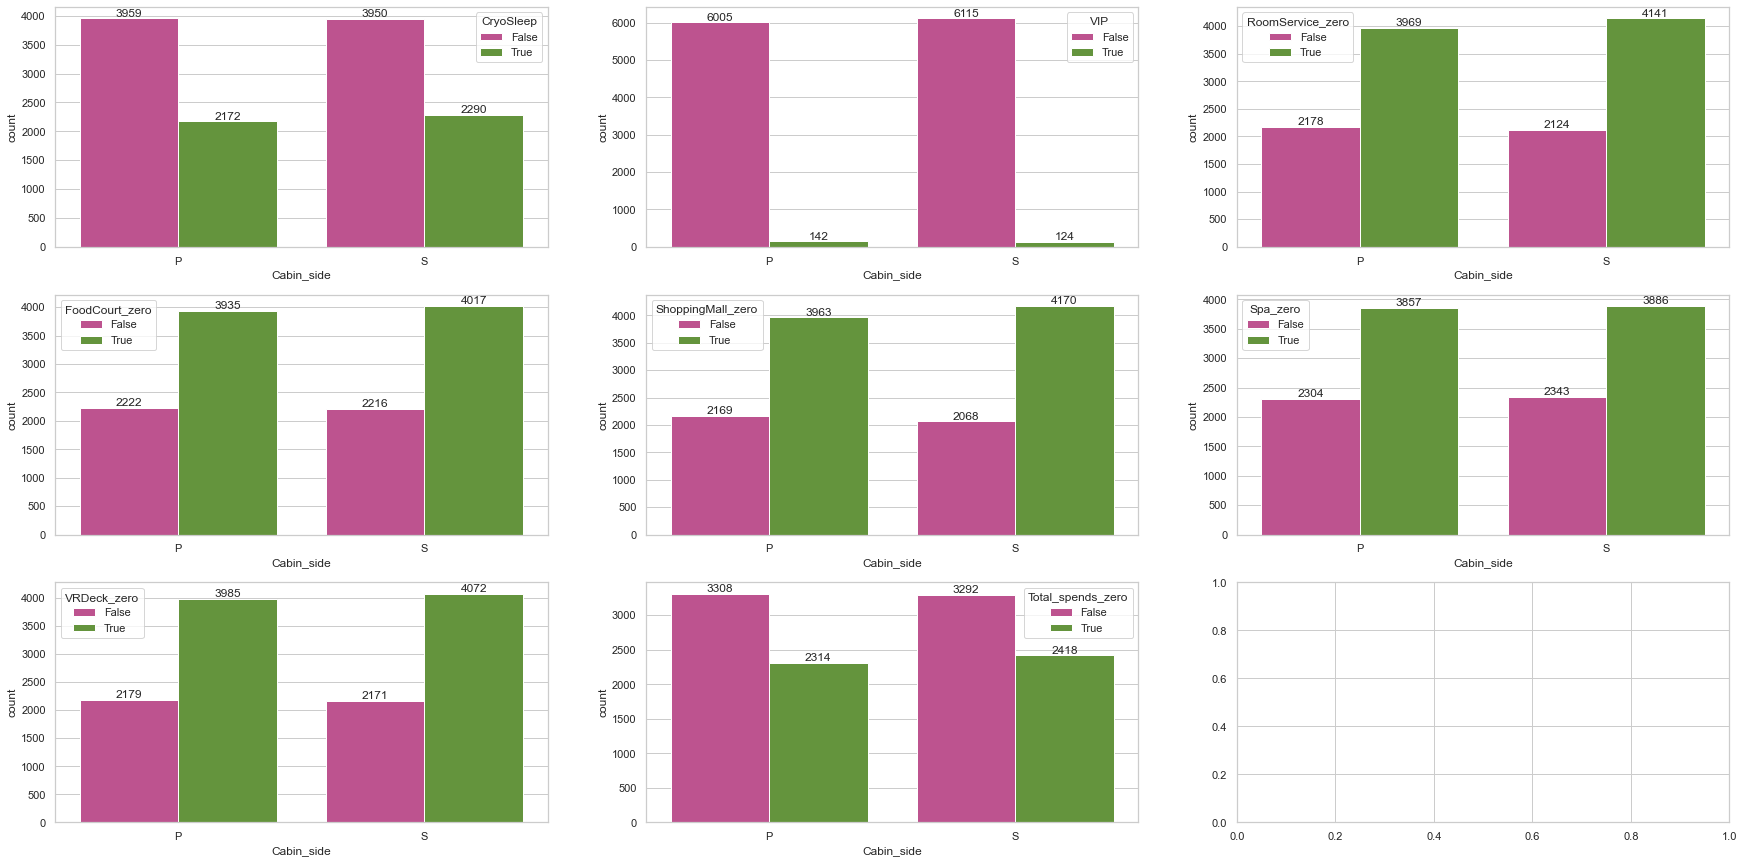

In [98]:
main_column = 'Cabin_side'
columns = [column for column in columns if column != main_column]

order = list(data[main_column][data[main_column].notna()].unique())
order.sort()

fig, axis = plt.subplots(3, 3, figsize=(30, 15))

for column, ax in zip(columns, axis.flat):
    sns.countplot(data = data, x = main_column, hue = column, ax = ax, palette = my_palette, order = order)
    for container in ax.containers:
        ax.bar_label(container, fontsize = 12)

sns.set_style("whitegrid");

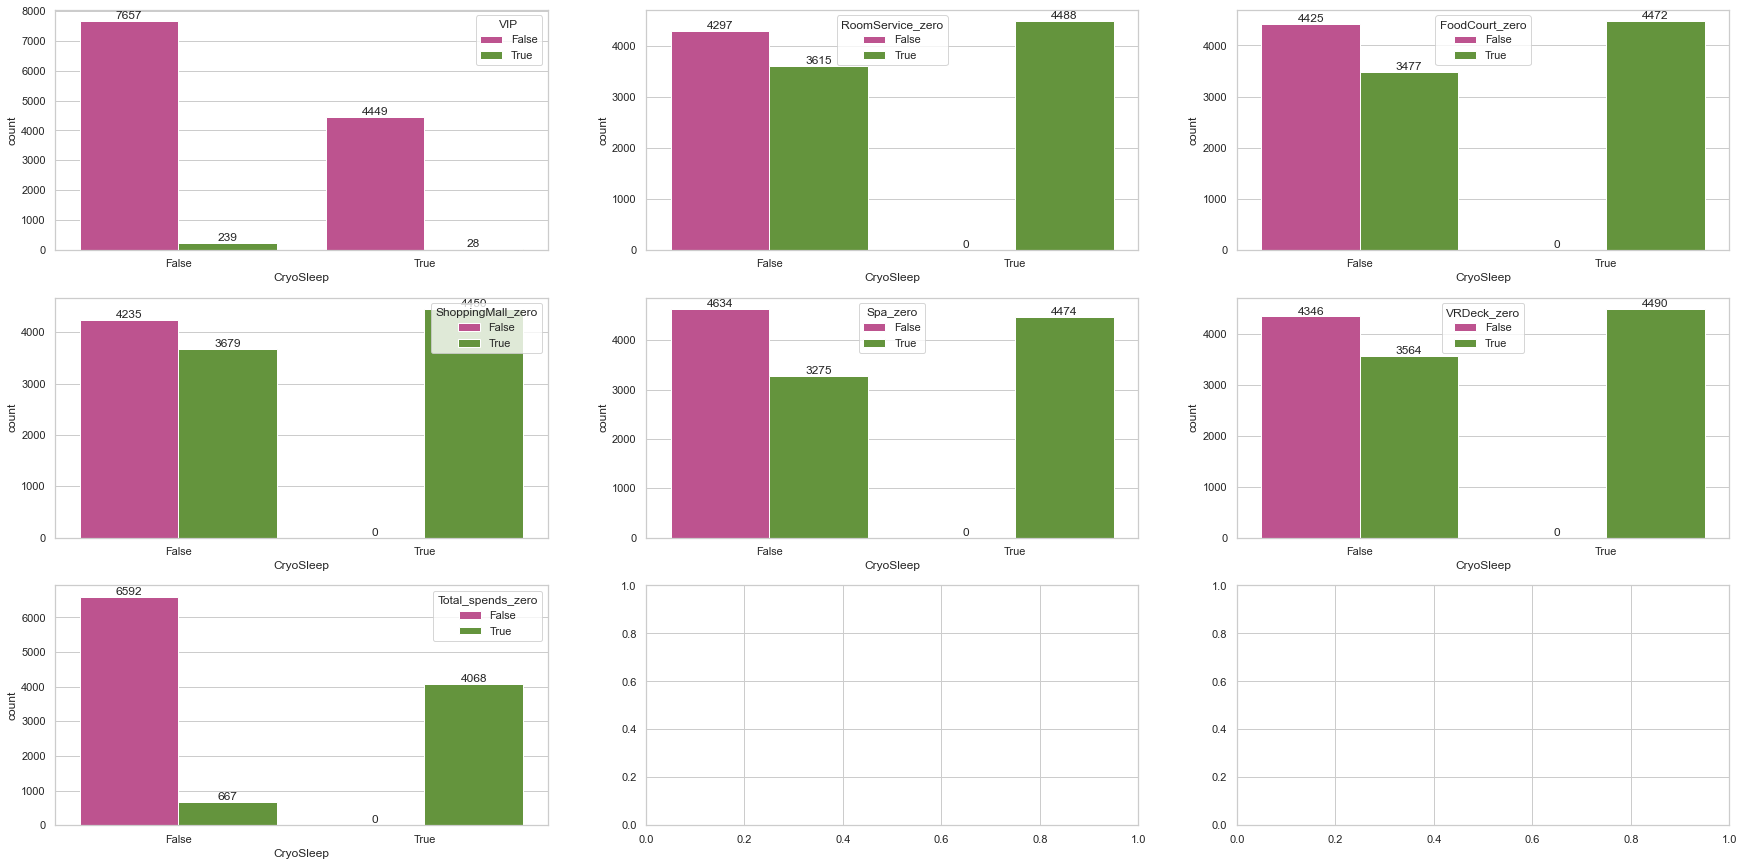

In [99]:
main_column = 'CryoSleep'
columns = [column for column in columns if column != main_column]

order = list(data[main_column][data[main_column].notna()].unique())
order.sort()

fig, axis = plt.subplots(3, 3, figsize=(30, 15))

for column, ax in zip(columns, axis.flat):
    sns.countplot(data = data, x = main_column, hue = column, ax = ax, palette = my_palette, order = order)
    for container in ax.containers:
        ax.bar_label(container, fontsize = 12)

sns.set_style("whitegrid");

Insights:
- Passengers in CryoSleep don't spend money on extra spends (RommService, FoodCourt, and etc). This seems logical: people who was in CryoSleep was putting into suspended animation for the duration of the voyage, so they can't spend money.

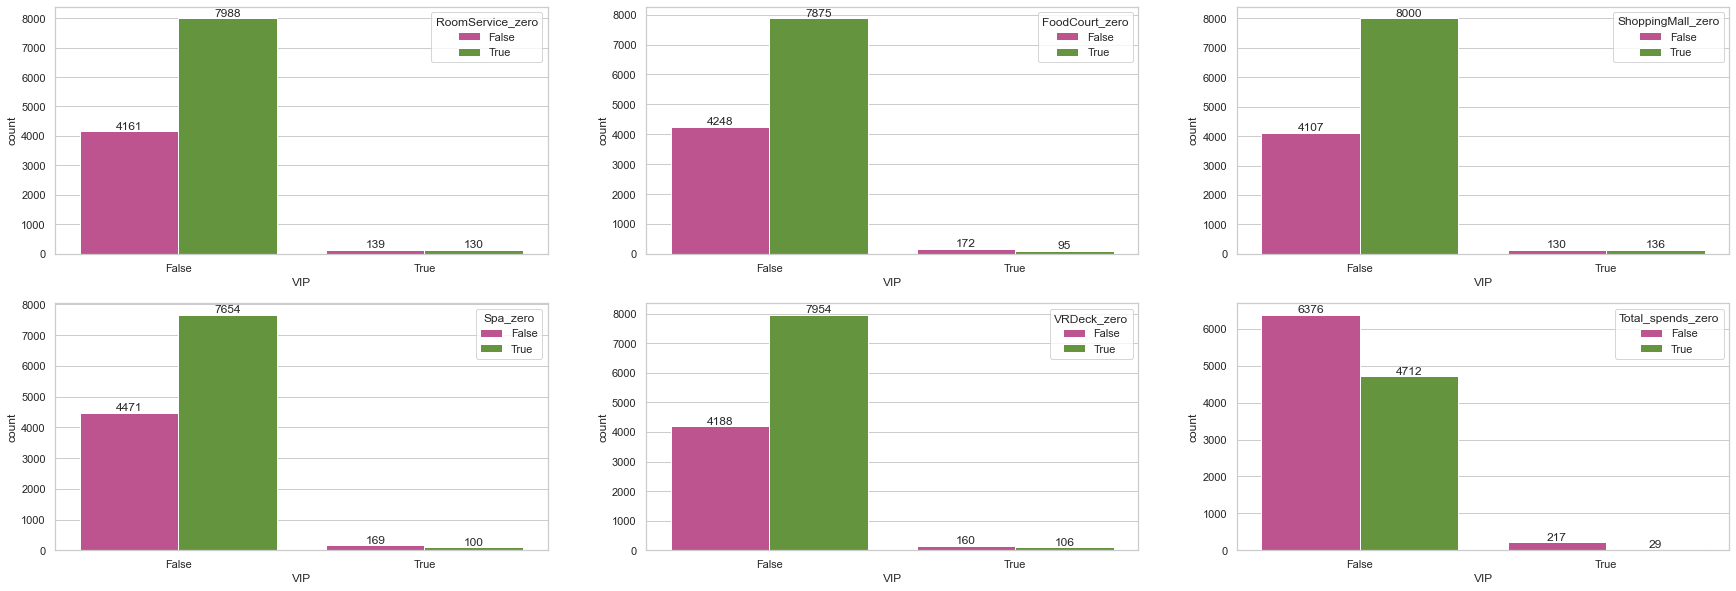

In [100]:
main_column = 'VIP'
columns = [column for column in columns if column != main_column]

order = list(data[main_column][data[main_column].notna()].unique())
order.sort()

fig, axis = plt.subplots(2, 3, figsize=(30, 10))

for column, ax in zip(columns, axis.flat):
    sns.countplot(data = data, x = main_column, hue = column, ax = ax, palette = my_palette, order = order)
    for container in ax.containers:
        ax.bar_label(container, fontsize = 12)

sns.set_style("whitegrid");

# **<span style="color:#4B0082;">Filling empty values.</span>**

First of all - we had a lot of insights that can help with filling empty values. And also we should check from time to time to see if they are violated.\
We need the following insights:
- Passengers in Age_group 0 doesn't spend money.
- No one from Age_group 0 and 1 had a VIP.
- All passengers from Cabin Decks A, B and C was from Europa.
- All passengers from Cabin Deck G was from Earth.
- No one from Cabin Deck D was from Earth.
- No one from Cabin Deck F was from Europa.
- No one from Cabin Deck G had a VIP.
- All passengers from Cabin Decks A and D was in Group_by_cabin_number 0.
- No one from Cabin Decks B, C and E was from Group_by_cabin_number 2 or 3.
- No one from Group_by_group_number 0 was in Group_by_cabin_number 3.
- No one from Group_by_cabin_number 2 or 3 was from Europa.
- No one from Earth had a VIP.
- Passengers in CryoSleep doesn't spend money.

And also I will make copy of our data, so that I can easily and quickly return it (or some of its values).

In [101]:
data_original = data.copy()
# data = data_original.copy()

In [102]:
data.drop(columns = ['Cabin_number', 'Age'], inplace = True)

In [103]:
def make_extra_columns(df):
    df = make_total_spends_column(df)
    df = make_zero_columns(df)
    df = make_groups_by_group_number(df)
    return df

data = make_extra_columns(data)

In [104]:
def check_conflicts_with_insights(df):
    for column in ['RoomService_zero', 'FoodCourt_zero', 'ShoppingMall_zero', 'Spa_zero', 'VRDeck_zero']:
        if df[(df['Age_group'] == 0) & (df[column] == False)].shape[0] > 0:
            print("Passengers of 12 years old and under doesn't spend money.", column, df[(df['Age_group'] == 0) & (df[column] == False)].shape[0])
        if df[(df['CryoSleep'] == True) & (df[column] == False)].shape[0] > 0:
            print("Passengers in CryoSleep doesn't spend money.", column, df[(df['CryoSleep'] == True) & (df[column] == False)].shape[0])
    if df[(df['Age_group'] <= 1) & (df['VIP'] == True)].shape[0] > 0:
        print("Passengers under 18 yo didn't have VIP.", df[(df['Age_group'] <= 1) & (df['VIP'] == True)].shape[0])
    for cabin_deck in ['A', 'B', 'C']:
        if df[(df['Cabin_deck'] == cabin_deck) & (df['HomePlanet'] != 'Europa') & (df['HomePlanet'].notna())].shape[0] > 0:
            print(f"All passengers from Cabin Deck {cabin_deck} was from Europa.", df[(df['Cabin_deck'] == cabin_deck) & (df['HomePlanet'] != 'Europe') & (df['HomePlanet'].notna())].shape[0])
    if df[(df['Cabin_deck'] == 'G') & (df['HomePlanet'] != 'Earth') & (df['HomePlanet'].notna())].shape[0] > 0:
        print("All passengers from Cabin Deck G was from Earth.", df[(df['Cabin_deck'] == 'G') & (df['HomePlanet'] != 'Earth') & (df['HomePlanet'].notna())].shape[0])
    if df[(df['Cabin_deck'] == 'D') & (df['HomePlanet'] == 'Earth')].shape[0] > 0:
        print("No one from Cabin Deck D was from Earth.", df[(df['Cabin_deck'] == 'D') & (df['HomePlanet'] == 'Earth')].shape[0])
    if df[(df['Cabin_deck'] == 'F') & (df['HomePlanet'] == 'Europa')].shape[0] > 0:
        print("No one from Cabin Deck F was from Europa.", df[(df['Cabin_deck'] == 'F') & (df['HomePlanet'] == 'Europa')].shape[0])
    if df[(df['Cabin_deck'] == 'G') & (df['VIP'] == True)].shape[0] > 0:
        print("No one from Cabin Deck G had a VIP.", df[(df['Cabin_deck'] == 'G') & (df['VIP'] == True)].shape[0])
    for cabin_deck in ['A', 'D']:
        if df[(df['Cabin_deck'] == cabin_deck) & (df['Group_by_cabin_number'] > 0)].shape[0] > 0:
            print(f"All passengers from Cabin Deck {cabin_deck} was in Group_by_cabin_number 0.", df[(df['Cabin_deck'] == cabin_deck) & (df['Group_by_cabin_number'] > 0)].shape[0])
    for cabin_deck in ['B', 'C', 'E']:
        if df[(df['Cabin_deck'] == cabin_deck) & ((df['Group_by_cabin_number'] == 2) | (df['Group_by_cabin_number'] == 3))].shape[0] > 0:
            print(f"No one from Cabin Deck {cabin_deck} was from Group_by_cabin_number 2 or 3.", df[(df['Cabin_deck'] == cabin_deck) & ((df['Group_by_cabin_number'] == 2) | (df['Group_by_cabin_number'] == 3))].shape[0])
    if df[(df['Group_by_group_number'] == 0) & (df['Group_by_cabin_number'] == 3)].shape[0] > 0:
        print("All passengers from Group_by_group_number 0 was in Group_by_cabin_number 3.", df[(df['Group_by_group_number'] == 0) & (df['Group_by_cabin_number'] == 3)].shape[0])
    for group_by_cabin_number in [2, 3]:
        if df[(df['Group_by_cabin_number'] == group_by_cabin_number) & (df['HomePlanet'] == 'Europa')].shape[0] > 0:
            print(f"No one from Group_by_cabin_number {group_by_cabin_number} was from Europa.", df[(df['Group_by_cabin_number'] == group_by_cabin_number) & (df['HomePlanet'] == 'Europa')].shape[0])
    if df[(df['HomePlanet'] == 'Earth') & (df['VIP'] == True)].shape[0] > 0:
        print("No one from Earth had a VIP.", df[(df['HomePlanet'] == 'Earth') & (df['VIP'] == True)].shape[0])

check_conflicts_with_insights(data)

In [105]:
missing_values = pd.DataFrame(data.isna().sum(), columns = ['Number_of_missing_values'])
missing_values['Percentage_of_missing_values'] = (100 * missing_values['Number_of_missing_values'] / data.shape[0]).round(3)
missing_values

,Number_of_missing_values,Percentage_of_missing_values
PassengerId,0,0.000
HomePlanet,288,2.221
CryoSleep,310,2.390
Destination,274,2.113
VIP,296,2.282
RoomService,263,2.028
FoodCourt,289,2.228
ShoppingMall,306,2.359
Spa,284,2.190
VRDeck,268,2.066


In [106]:
def fill_by_insights(df):
    for column in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Total_spends']:
        df.loc[df['Age_group'] == 0, column] = 0
        df.loc[df['CryoSleep'] == True, column] = 0
        df.loc[df[column] > 0, 'CryoSleep'] = False
    df.loc[df['Age_group'] <= 1, 'VIP'] = False
    df.loc[df['VIP'] == True, 'Age_group'] = 2
    for cabin_deck in ['A', 'B', 'C']:
        df.loc[df['Cabin_deck'] == cabin_deck, 'HomePlanet'] = 'Europa'
    df.loc[df['Cabin_deck'] == 'G', 'HomePlanet'] = 'Earth'
    df.loc[df['Cabin_deck'] == 'G', 'VIP'] = False
    for cabin_deck in ['A', 'D']:
        df.loc[df['Cabin_deck'] == cabin_deck, 'Group_by_cabin_number'] = 0
    df.loc[df['HomePlanet'] == 'Earth', 'VIP'] = False
    return df

data = fill_by_insights(data)
data = make_extra_columns(data)
check_conflicts_with_insights(data)

In [107]:
missing_values['Number_of_missing_values_after_filling_by_insights'] = data.isna().sum()
missing_values['Percentage_of_missing_values_after_filling_by_insights'] = (100 * missing_values['Number_of_missing_values_after_filling_by_insights'] / data.shape[0]).round(3)
missing_values

,Number_of_missing_values,Percentage_of_missing_values,Number_of_missing_values_after_filling_by_insights,Percentage_of_missing_values_after_filling_by_insights
PassengerId,0,0.000,0,0.000
HomePlanet,288,2.221,161,1.241
CryoSleep,310,2.390,136,1.049
Destination,274,2.113,274,2.113
VIP,296,2.282,124,0.956
RoomService,263,2.028,162,1.249
FoodCourt,289,2.228,171,1.318
ShoppingMall,306,2.359,163,1.257
Spa,284,2.190,166,1.280
VRDeck,268,2.066,150,1.157


We already filled a lot of missing values.\
Now I will fill the remaining empty values with an IterativeImputer.

In [108]:
dict_label_mapping = {}
dict_label_mapping_r = {}

cat_columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Last_name', 'Cabin_deck', 'Cabin_side']

for column in cat_columns:
    le = LabelEncoder().fit(data[column].drop_duplicates().dropna())
    data[column][data[column].notna()] = le.transform(data[column][data[column].notna()])
    dict_label_mapping[column] = dict(zip(le.transform(le.classes_), le.classes_))
    dict_label_mapping_r[column] = dict(zip(le.classes_, le.transform(le.classes_)))

data.head()

,PassengerId,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Total_spends,Group_by_group_number,Group_by_cabin_number,RoomService_zero,FoodCourt_zero,ShoppingMall_zero,Spa_zero,VRDeck_zero,Total_spends_zero,Age_group
0,0001_01,1,0,2,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,True,True,True,True,True,True,2.0
1,0002_01,0,0,2,0,109.0,9.0,25.0,549.0,44.0,...,736.0,0.0,0.0,False,False,False,False,False,False,2.0
2,0003_01,1,0,2,1,43.0,3576.0,0.0,6715.0,49.0,...,10383.0,0.0,0.0,False,False,True,False,False,False,2.0
3,0003_02,1,0,2,0,0.0,1283.0,371.0,3329.0,193.0,...,5176.0,0.0,0.0,True,False,False,False,False,False,2.0
4,0004_01,0,0,2,0,303.0,70.0,151.0,565.0,2.0,...,1091.0,0.0,0.0,False,False,False,False,False,False,1.0


In [109]:
passenger_id = data['PassengerId']
data_transported = data['Transported']
data_train = data['train']

data.drop(columns = ['RoomService_zero', 'FoodCourt_zero', 'ShoppingMall_zero', 'Spa_zero', 'VRDeck_zero', 'Total_spends_zero', 'PassengerId', 'Transported', 'train', 'Total_spends'], inplace = True)

data.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_number,Last_name,Cabin_deck,Cabin_side,Group_by_group_number,Group_by_cabin_number,Age_group
0,1,0,2,0,0.0,0.0,0.0,0.0,0.0,1,1551,1,0,0.0,0.0,2.0
1,0,0,2,0,109.0,9.0,25.0,549.0,44.0,2,2289,5,1,0.0,0.0,2.0
2,1,0,2,1,43.0,3576.0,0.0,6715.0,49.0,3,2153,0,1,0.0,0.0,2.0
3,1,0,2,0,0.0,1283.0,371.0,3329.0,193.0,3,2153,0,1,0.0,0.0,2.0
4,0,0,2,0,303.0,70.0,151.0,565.0,2.0,4,1924,5,1,0.0,0.0,1.0


In [110]:
data_nunique = pd.DataFrame(data.nunique(), columns=['Number_of_unique_values'])
data_nunique

,Number_of_unique_values
HomePlanet,3
CryoSleep,2
Destination,3
VIP,2
RoomService,1578
FoodCourt,1953
ShoppingMall,1367
Spa,1679
VRDeck,1642
Group_number,9280


In [111]:
imputer = IterativeImputer(random_state = 18, min_value = [data[column].min() for column in data.columns], max_value = [data[column].max() for column in data.columns])
data = pd.DataFrame(np.round(imputer.fit_transform(data)),columns = data.columns)
data_nunique['Number_of_unique_values_after_imputer'] = data.nunique()
data_nunique[data_nunique['Number_of_unique_values_after_imputer'] != data_nunique['Number_of_unique_values']]

,Number_of_unique_values,Number_of_unique_values_after_imputer
RoomService,1578,1593
FoodCourt,1953,1998
ShoppingMall,1367,1378
Spa,1679,1705
VRDeck,1642,1656


In [112]:
for column in dict_label_mapping.keys():
    data.replace({column: dict_label_mapping[column]}, inplace=True)

data.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_number,Last_name,Cabin_deck,Cabin_side,Group_by_group_number,Group_by_cabin_number,Age_group
0,Europa,False,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,1.0,Ofracculy,B,P,0.0,0.0,2.0
1,Earth,False,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,2.0,Vines,F,S,0.0,0.0,2.0
2,Europa,False,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,3.0,Susent,A,S,0.0,0.0,2.0
3,Europa,False,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,3.0,Susent,A,S,0.0,0.0,2.0
4,Earth,False,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,4.0,Santantines,F,S,0.0,0.0,1.0


In [113]:
data = make_extra_columns(data)

Now let's look at conflicts with our insights after filling by IterativeImputer.

In [114]:
check_conflicts_with_insights(data)

Passengers in CryoSleep doesn't spend money. ShoppingMall_zero 1
Passengers in CryoSleep doesn't spend money. Spa_zero 2
All passengers from Cabin Deck C was from Europa. 1107
All passengers from Cabin Deck G was from Earth. 1
No one from Cabin Deck D was from Earth. 1
No one from Cabin Deck F was from Europa. 61
All passengers from Cabin Deck D was in Group_by_cabin_number 0. 32
No one from Cabin Deck C was from Group_by_cabin_number 2 or 3. 1
No one from Cabin Deck E was from Group_by_cabin_number 2 or 3. 23
No one from Group_by_cabin_number 2 was from Europa. 34
No one from Group_by_cabin_number 3 was from Europa. 26


So... We have a lot of disagreements with insights. I will fill back the values for rows with disagreements, and fill carefully all of this rows with KNN imputer on the base of rows that don't have disagreements with insights.

In [115]:
data['PassengerId'] = passenger_id

data.loc[(data['CryoSleep'] == True) & (data['ShoppingMall_zero'] == False), 'CryoSleep'] = data.loc[(data['CryoSleep'] == True) & (data['ShoppingMall_zero'] == False), 'PassengerId'].apply(lambda x: data_original['CryoSleep'][data_original['PassengerId'] == x])
data.loc[(data['CryoSleep'] == True) & (data['ShoppingMall_zero'] == False), 'ShoppingMall'] = data.loc[(data['CryoSleep'] == True) & (data['ShoppingMall_zero'] == False), 'PassengerId'].apply(lambda x: data_original['ShoppingMall'][data_original['PassengerId'] == x])

data.loc[(data['CryoSleep'] == True) & (data['Spa_zero'] == False), 'CryoSleep'] = data.loc[(data['CryoSleep'] == True) & (data['Spa_zero'] == False), 'PassengerId'].apply(lambda x: data_original['CryoSleep'][data_original['PassengerId'] == x])
data.loc[(data['CryoSleep'] == True) & (data['Spa_zero'] == False), 'Spa'] = data.loc[(data['CryoSleep'] == True) & (data['Spa_zero'] == False), 'PassengerId'].apply(lambda x: data_original['Spa'][data_original['PassengerId'] == x])


data.loc[(data['Cabin_deck'] == 'C') & (data['HomePlanet'] != 'Europa'), 'Cabin_deck'] = data.loc[(data['Cabin_deck'] == 'C') & (data['HomePlanet'] != 'Europa'), 'PassengerId'].apply(lambda x: data_original['Cabin_deck'][data_original['PassengerId'] == x])
data.loc[(data['Cabin_deck'] == 'C') & (data['HomePlanet'] != 'Europa'), 'HomePlanet'] = data.loc[(data['Cabin_deck'] == 'C') & (data['HomePlanet'] != 'Europa'), 'PassengerId'].apply(lambda x: data_original['HomePlanet'][data_original['PassengerId'] == x])

data.loc[(data['Cabin_deck'] == 'G') & (data['HomePlanet'] != 'Earth'), 'Cabin_deck'] = data.loc[(data['Cabin_deck'] == 'G') & (data['HomePlanet'] != 'Earth'), 'PassengerId'].apply(lambda x: data_original['Cabin_deck'][data_original['PassengerId'] == x])
data.loc[(data['Cabin_deck'] == 'G') & (data['HomePlanet'] != 'Earth'), 'HomePlanet'] = data.loc[(data['Cabin_deck'] == 'G') & (data['HomePlanet'] != 'Earth'), 'PassengerId'].apply(lambda x: data_original['HomePlanet'][data_original['PassengerId'] == x])

data.loc[(data['Cabin_deck'] == 'D') & (data['HomePlanet'] == 'Earth'), 'Cabin_deck'] = data.loc[(data['Cabin_deck'] == 'D') & (data['HomePlanet'] == 'Earth'), 'PassengerId'].apply(lambda x: data_original['Cabin_deck'][data_original['PassengerId'] == x])
data.loc[(data['Cabin_deck'] == 'D') & (data['HomePlanet'] == 'Earth'), 'HomePlanet'] = data.loc[(data['Cabin_deck'] == 'D') & (data['HomePlanet'] == 'Earth'), 'PassengerId'].apply(lambda x: data_original['HomePlanet'][data_original['PassengerId'] == x])

data.loc[(data['Cabin_deck'] == 'F') & (data['HomePlanet'] == 'Europa'), 'Cabin_deck'] = data.loc[(data['Cabin_deck'] == 'F') & (data['HomePlanet'] == 'Europa'), 'PassengerId'].apply(lambda x: data_original['Cabin_deck'][data_original['PassengerId'] == x])
data.loc[(data['Cabin_deck'] == 'F') & (data['HomePlanet'] == 'Europa'), 'Cabin_deck'] = data.loc[(data['Cabin_deck'] == 'F') & (data['HomePlanet'] == 'Europa'), 'PassengerId'].apply(lambda x: data_original['Cabin_deck'][data_original['PassengerId'] == x])

data.loc[(data['Cabin_deck'] == 'D') & (data['Group_by_cabin_number'] != 0), 'Cabin_deck'] = data.loc[(data['Cabin_deck'] == 'D') & (data['Group_by_cabin_number'] != 0), 'PassengerId'].apply(lambda x: data_original['Cabin_deck'][data_original['PassengerId'] == x])
data.loc[(data['Cabin_deck'] == 'D') & (data['Group_by_cabin_number'] != 0), 'Group_by_cabin_number'] = data.loc[(data['Cabin_deck'] == 'D') & (data['Group_by_cabin_number'] != 0), 'PassengerId'].apply(lambda x: data_original['Group_by_cabin_number'][data_original['PassengerId'] == x])

data.loc[((data['Cabin_deck'] == 'C') | (data['Cabin_deck'] == 'E')) & ((data['Group_by_cabin_number'] == 2) | (data['Group_by_cabin_number'] == 3)), 'Cabin_deck'] = data.loc[((data['Cabin_deck'] == 'C') | (data['Cabin_deck'] == 'E')) & ((data['Group_by_cabin_number'] == 2) | (data['Group_by_cabin_number'] == 3)), 'PassengerId'].apply(lambda x: data_original['Cabin_deck'][data_original['PassengerId'] == x])
data.loc[((data['Cabin_deck'] == 'C') | (data['Cabin_deck'] == 'E')) & ((data['Group_by_cabin_number'] == 2) | (data['Group_by_cabin_number'] == 3)), 'Group_by_cabin_number'] = data.loc[((data['Cabin_deck'] == 'C') | (data['Cabin_deck'] == 'E')) & ((data['Group_by_cabin_number'] == 2) | (data['Group_by_cabin_number'] == 3)), 'PassengerId'].apply(lambda x: data_original['Group_by_cabin_number'][data_original['PassengerId'] == x])

data.loc[((data['Group_by_cabin_number'] == 2) | (data['Group_by_cabin_number'] == 3)) & (data['HomePlanet'] == 'Europa'), 'Group_by_cabin_number'] = data.loc[((data['Group_by_cabin_number'] == 2) | (data['Group_by_cabin_number'] == 3)) & (data['HomePlanet'] == 'Europa'), 'PassengerId'].apply(lambda x: data_original['Group_by_cabin_number'][data_original['PassengerId'] == x])
data.loc[((data['Group_by_cabin_number'] == 2) | (data['Group_by_cabin_number'] == 3)) & (data['HomePlanet'] == 'Europa'), 'HomePlanet'] = data.loc[((data['Group_by_cabin_number'] == 2) | (data['Group_by_cabin_number'] == 3)) & (data['HomePlanet'] == 'Europa'), 'PassengerId'].apply(lambda x: data_original['HomePlanet'][data_original['PassengerId'] == x])

data.drop(columns = ['Group_by_group_number', 'RoomService_zero', 'FoodCourt_zero', 'ShoppingMall_zero', 'Spa_zero', 'VRDeck_zero', 'Total_spends_zero', 'Total_spends'], inplace = True)
data = make_extra_columns(data)
check_conflicts_with_insights(data)

Let's fill by insights and look at the number of missing values.

In [116]:
data = fill_by_insights(data)
data = make_extra_columns(data)
check_conflicts_with_insights(data)

In [117]:
data.isna().sum()

HomePlanet                 0
CryoSleep                  0
Destination                0
VIP                        0
RoomService                0
FoodCourt                  0
ShoppingMall               0
Spa                        0
VRDeck                     0
Group_number               0
Last_name                  0
Cabin_deck               120
Cabin_side                 0
Group_by_cabin_number     60
Age_group                  0
PassengerId                0
Total_spends               0
RoomService_zero           0
FoodCourt_zero             0
ShoppingMall_zero          0
Spa_zero                   0
VRDeck_zero                0
Total_spends_zero          0
Group_by_group_number      0
dtype: int64

Now we have missing values in Cabin_deck, and in Group_by_cabin_number features. Insights with this features:
- All passengers from Cabin Decks A, B and C was from Europa.
- All passengers from Cabin Deck G was from Earth.
- No one from Cabin Deck D was from Earth.
- No one from Cabin Deck F was from Europa.
- All passengers from Cabin Decks A and D was in Group_by_cabin_number 0.
- No one from Cabin Decks B, C and E was from Group_by_cabin_number 2 or 3.
- No one from Group_by_group_number 0 was in Group_by_cabin_number 3.
- No one from Group_by_cabin_number 2 or 3 was from Europa.

Let's fill missing values with KNNImputer by HomePlanet.
For example, we know, that no one from Cabin Deck D was from Earth. I will fill empty on a part of the dataframe with HomePlanet Mars. After with HomePlanet Europa. And so on.

In [118]:
data[['Cabin_deck', 'Group_by_cabin_number']].isna().sum()

Cabin_deck               120
Group_by_cabin_number     60
dtype: int64

In [119]:
data_part = data[data['HomePlanet'] == 'Earth'].copy()

data_part.reset_index(drop = True, inplace = True)

data_part_passengerid = data_part['PassengerId']

data_part.drop(columns = ['RoomService_zero', 'FoodCourt_zero', 'ShoppingMall_zero', 'Spa_zero', 'VRDeck_zero', 'Total_spends_zero', 'PassengerId', 'Total_spends'], inplace = True)

for column in dict_label_mapping_r.keys():
    data_part.replace({column: dict_label_mapping_r[column]}, inplace=True)

imputer = KNN(verbose = False)
data_part = pd.DataFrame(np.round(imputer.fit_transform(data_part)), columns = data_part.columns)

data_part['PassengerId'] = data_part_passengerid

for column in dict_label_mapping.keys():
    data_part.replace({column: dict_label_mapping[column]}, inplace=True)

data_part_group_by_cabin_number = data_part.set_index('PassengerId')['Group_by_cabin_number']
data_part_cabin_deck = data_part.set_index('PassengerId')['Cabin_deck']

data.loc[(data['Cabin_deck'].isna()) & (data['HomePlanet'] == 'Earth'), 'Cabin_deck'] = data.loc[(data['Cabin_deck'].isna()) & (data['HomePlanet'] == 'Earth'), 'Cabin_deck'].fillna(data['PassengerId'].map(data_part_cabin_deck))
data.loc[(data['Group_by_cabin_number'].isna()) & (data['HomePlanet'] == 'Earth'), 'Group_by_cabin_number'] = data.loc[(data['Group_by_cabin_number'].isna()) & (data['HomePlanet'] == 'Earth'), 'Group_by_cabin_number'].fillna(data['PassengerId'].map(data_part_group_by_cabin_number))

data = make_extra_columns(data)
check_conflicts_with_insights(data)
data[['Cabin_deck', 'Group_by_cabin_number']].isna().sum()

Cabin_deck               116
Group_by_cabin_number     60
dtype: int64

In [120]:
data_part = data[data['HomePlanet'] == 'Europa'].copy()

data_part.reset_index(drop = True, inplace = True)

data_part_passengerid = data_part['PassengerId']

data_part.drop(columns = ['RoomService_zero', 'FoodCourt_zero', 'ShoppingMall_zero', 'Spa_zero', 'VRDeck_zero', 'Total_spends_zero', 'PassengerId', 'Total_spends'], inplace = True)

for column in dict_label_mapping_r.keys():
    data_part.replace({column: dict_label_mapping_r[column]}, inplace=True)

imputer = KNN(verbose = False)
data_part = pd.DataFrame(np.round(imputer.fit_transform(data_part)), columns = data_part.columns)

data_part['PassengerId'] = data_part_passengerid

for column in dict_label_mapping.keys():
    data_part.replace({column: dict_label_mapping[column]}, inplace=True)

data_part_group_by_cabin_number = data_part.set_index('PassengerId')['Group_by_cabin_number']
data_part_cabin_deck = data_part.set_index('PassengerId')['Cabin_deck']

data.loc[(data['Cabin_deck'].isna()) & (data['HomePlanet'] == 'Europa'), 'Cabin_deck'] = data.loc[(data['Cabin_deck'].isna()) & (data['HomePlanet'] == 'Europa'), 'Cabin_deck'].fillna(data['PassengerId'].map(data_part_cabin_deck))
data.loc[(data['Group_by_cabin_number'].isna()) & (data['HomePlanet'] == 'Europa'), 'Group_by_cabin_number'] = data.loc[(data['Group_by_cabin_number'].isna()) & (data['HomePlanet'] == 'Europa'), 'Group_by_cabin_number'].fillna(data['PassengerId'].map(data_part_group_by_cabin_number))

data = make_extra_columns(data)
check_conflicts_with_insights(data)
data[['Cabin_deck', 'Group_by_cabin_number']].isna().sum()

All passengers from Cabin Deck A was in Group_by_cabin_number 0. 1
All passengers from Cabin Deck D was in Group_by_cabin_number 0. 6


Cabin_deck               27
Group_by_cabin_number     0
dtype: int64

We again have conflicts with insights. Let's return values in this rows to original. After that I will do this filling approach with the last HomePlanet Mars and will try filling in a different way.

In [121]:
data.loc[((data['Cabin_deck'] == 'D') | (data['Cabin_deck'] == 'A'))  & (data['Group_by_cabin_number'] != 0), 'Cabin_deck'] = data.loc[((data['Cabin_deck'] == 'D') | (data['Cabin_deck'] == 'A')) & (data['Group_by_cabin_number'] != 0), 'PassengerId'].apply(lambda x: data_original['Cabin_deck'][data_original['PassengerId'] == x])
data.loc[((data['Cabin_deck'] == 'D') | (data['Cabin_deck'] == 'A')) & (data['Group_by_cabin_number'] != 0), 'Group_by_cabin_number'] = data.loc[((data['Cabin_deck'] == 'D') | (data['Cabin_deck'] == 'A')) & (data['Group_by_cabin_number'] != 0), 'PassengerId'].apply(lambda x: data_original['Group_by_cabin_number'][data_original['PassengerId'] == x])

data = make_extra_columns(data)
check_conflicts_with_insights(data)
data[['Cabin_deck', 'Group_by_cabin_number']].isna().sum()

Cabin_deck               34
Group_by_cabin_number     0
dtype: int64

At least we have completely filled missing values in Group_by_cabin_number feature.

In [122]:
data_part = data[data['HomePlanet'] == 'Mars'].copy()

data_part.reset_index(drop = True, inplace = True)

data_part_passengerid = data_part['PassengerId']

data_part.drop(columns = ['RoomService_zero', 'FoodCourt_zero', 'ShoppingMall_zero', 'Spa_zero', 'VRDeck_zero', 'Total_spends_zero', 'PassengerId', 'Total_spends'], inplace = True)

for column in dict_label_mapping_r.keys():
    data_part.replace({column: dict_label_mapping_r[column]}, inplace=True)

imputer = KNN(verbose = False)
data_part = pd.DataFrame(np.round(imputer.fit_transform(data_part)), columns = data_part.columns)

data_part['PassengerId'] = data_part_passengerid

for column in dict_label_mapping.keys():
    data_part.replace({column: dict_label_mapping[column]}, inplace=True)

data_part_group_by_cabin_number = data_part.set_index('PassengerId')['Group_by_cabin_number']
data_part_cabin_deck = data_part.set_index('PassengerId')['Cabin_deck']

data.loc[(data['Cabin_deck'].isna()) & (data['HomePlanet'] == 'Mars'), 'Cabin_deck'] = data.loc[(data['Cabin_deck'].isna()) & (data['HomePlanet'] == 'Mars'), 'Cabin_deck'].fillna(data['PassengerId'].map(data_part_cabin_deck))

data = make_extra_columns(data)
check_conflicts_with_insights(data)
data['Cabin_deck'].isna().sum()

No one from Cabin Deck E was from Group_by_cabin_number 2 or 3. 6


7

In [123]:
data.loc[(data['Cabin_deck'] == 'E') & ((data['Group_by_cabin_number'] == 2) | (data['Group_by_cabin_number'] == 3)), 'Cabin_deck'] = data.loc[(data['Cabin_deck'] == 'E') & ((data['Group_by_cabin_number'] == 2) | (data['Group_by_cabin_number'] == 3)), 'PassengerId'].apply(lambda x: data_original['Cabin_deck'][data_original['PassengerId'] == x])
data.loc[(data['Cabin_deck'] == 'E') & ((data['Group_by_cabin_number'] == 2) | (data['Group_by_cabin_number'] == 3)), 'Group_by_cabin_number'] = data.loc[(data['Cabin_deck'] == 'E') & ((data['Group_by_cabin_number'] == 2) | (data['Group_by_cabin_number'] == 3)), 'PassengerId'].apply(lambda x: data_original['Group_by_cabin_number'][data_original['PassengerId'] == x])

data = fill_by_insights(data)
data = make_extra_columns(data)
check_conflicts_with_insights(data)
data['Cabin_deck'].isna().sum()

13

No we have missing values only in Cabin_deck feature. Let's look at the histogram graphs between this feature and the others.

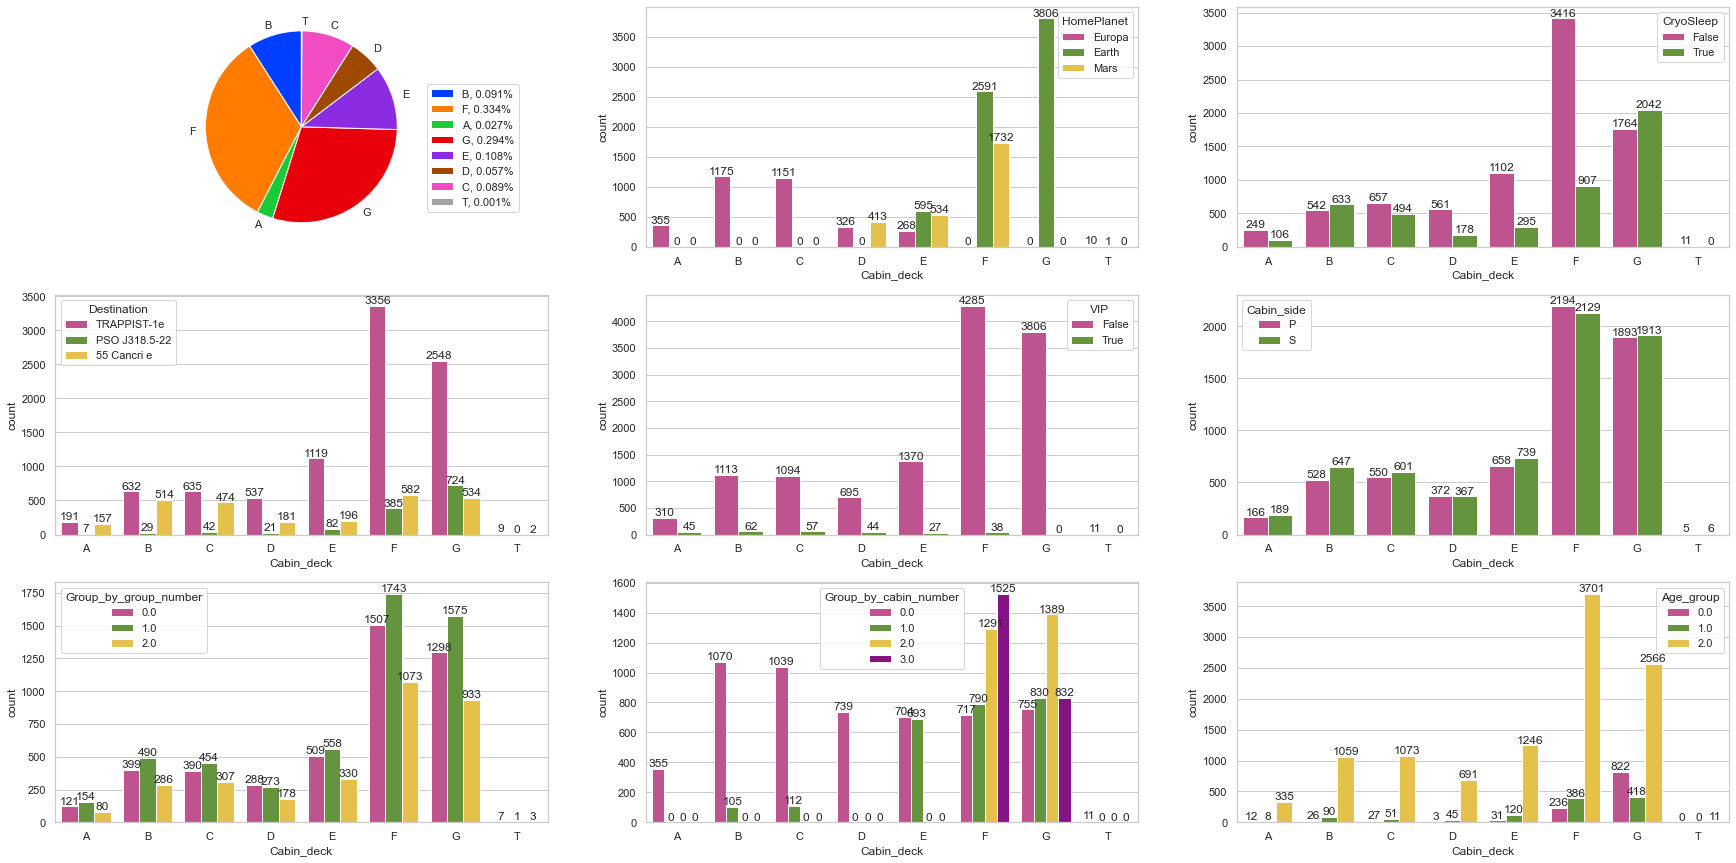

In [124]:
columns = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_side', 'Group_by_group_number', 'Group_by_cabin_number', 'Age_group']

main_column = 'Cabin_deck'

order = list(data[main_column][data[main_column].notna()].unique())
order.sort()

fig, axis = plt.subplots(3, 3, figsize=(30, 15))

for column, ax in zip(columns, axis.flat[1:]):
    sns.countplot(data = data, x = main_column, hue = column, ax = ax, palette = my_palette, order = order)
    for container in ax.containers:
        ax.bar_label(container, fontsize = 12)

labels = list(data[main_column][data[main_column].notna()].unique())
sizes = [data[data[main_column] == i].shape[0] for i in labels]
axis[0][0].pie(sizes, labels = labels, startangle = 90, colors = sns.color_palette('bright'))

sizes = [size/data[data[main_column].notna()].shape[0] for size in sizes]
labels = [f'{l}, {s:0.3f}%' for l, s in zip(labels, sizes)]
axis[0][0].legend(bbox_to_anchor = (1, 0.7), labels = labels)

sns.set_style("whitegrid");

What can we say about each of the cabins?
- A: from HomePlanet Europa, destination - not PSO J318, Group_by_cabin_number - 0.
- B and C: from HomePlanet Europa, Group_by_cabin_number - 0 or 1.
- D: from HomePlanet Europa or Mars, Group_by_cabin_number - 0.
- E: Group_by_cabin_number - 0 or 1.
- F: from HomePlanet Earth or Mars.
- G: from HomePlanet Earth, don't have VIP.
- T: too small.

In [125]:
data[(data['HomePlanet'] == 'Europa') & (data['Group_by_cabin_number'] == 0) & (data['Destination'] != 'PSO J318.5-22') & (data['Cabin_deck'].isna())].shape[0]

0

In [126]:
data[(data['HomePlanet'] == 'Europa') & (data['Group_by_cabin_number'] <= 1) & (data['Cabin_deck'].isna())].shape[0]

7

In [127]:
data_part = data[(data['HomePlanet'] == 'Europa') & (data['Group_by_cabin_number'] <= 1) & ((data['Cabin_deck'] == 'B') | (data['Cabin_deck'] == 'C') | (data['Cabin_deck'].isna()))].copy()

data_part.reset_index(drop = True, inplace = True)

data_part_passengerid = data_part['PassengerId']

data_part.drop(columns = ['RoomService_zero', 'FoodCourt_zero', 'ShoppingMall_zero', 'Spa_zero', 'VRDeck_zero', 'Total_spends_zero', 'PassengerId', 'Total_spends'], inplace = True)

for column in dict_label_mapping_r.keys():
    data_part.replace({column: dict_label_mapping_r[column]}, inplace=True)

imputer = KNN(verbose = False)
data_part = pd.DataFrame(np.round(imputer.fit_transform(data_part)), columns = data_part.columns)

data_part['PassengerId'] = data_part_passengerid

for column in dict_label_mapping.keys():
    data_part.replace({column: dict_label_mapping[column]}, inplace=True)

data_part_group_by_cabin_number = data_part.set_index('PassengerId')['Group_by_cabin_number']
data_part_cabin_deck = data_part.set_index('PassengerId')['Cabin_deck']

data.loc[(data['Cabin_deck'].isna()) & (data['HomePlanet'] == 'Europa') & (data['Group_by_cabin_number'] <= 1), 'Cabin_deck'] = data.loc[(data['Cabin_deck'].isna()) & (data['HomePlanet'] == 'Europa') & (data['Group_by_cabin_number'] <= 1), 'Cabin_deck'].fillna(data['PassengerId'].map(data_part_cabin_deck))

data = make_extra_columns(data)
check_conflicts_with_insights(data)
data['Cabin_deck'].isna().sum()

6

What do we have left?

In [128]:
data[data['Cabin_deck'].isna()]

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_number,...,Age_group,PassengerId,Total_spends,RoomService_zero,FoodCourt_zero,ShoppingMall_zero,Spa_zero,VRDeck_zero,Total_spends_zero,Group_by_group_number
6601,Mars,False,TRAPPIST-1e,False,3358.0,1.0,12.0,0.0,0.0,6970.0,...,2.0,6970_01,3371.0,False,False,False,True,True,False,2.0
7543,Mars,True,TRAPPIST-1e,False,0.0,0.0,0,0,0.0,8064.0,...,2.0,8064_01,0.0,True,True,True,True,True,True,2.0
7708,Mars,False,TRAPPIST-1e,False,85.0,0.0,1130.0,0.0,248.0,8225.0,...,1.0,8225_01,1463.0,False,True,False,True,False,False,2.0
11896,Mars,False,TRAPPIST-1e,False,1718.0,0.0,868.0,636.0,0.0,7009.0,...,2.0,7009_02,3222.0,False,True,False,False,True,False,2.0
12322,Mars,False,TRAPPIST-1e,False,1857.0,0.0,26.0,0.0,0.0,7915.0,...,2.0,7915_02,1883.0,False,True,False,True,True,False,2.0
12869,Mars,False,TRAPPIST-1e,False,784.0,0.0,42.0,38.0,10.0,9058.0,...,2.0,9058_01,874.0,False,True,False,False,False,False,2.0


These values are only suitable for Cabin_decks F and T.

In [129]:
data_part = data[((data['Cabin_deck'] == 'T') | (data['Cabin_deck'] == 'F') | (data['Cabin_deck'].isna()))].copy()

data_part.reset_index(drop = True, inplace = True)

data_part_passengerid = data_part['PassengerId']

data_part.drop(columns = ['RoomService_zero', 'FoodCourt_zero', 'ShoppingMall_zero', 'Spa_zero', 'VRDeck_zero', 'Total_spends_zero', 'PassengerId', 'Total_spends'], inplace = True)

for column in dict_label_mapping_r.keys():
    data_part.replace({column: dict_label_mapping_r[column]}, inplace=True)

imputer = KNN(verbose = False)
data_part = pd.DataFrame(np.round(imputer.fit_transform(data_part)), columns = data_part.columns)

data_part['PassengerId'] = data_part_passengerid

for column in dict_label_mapping.keys():
    data_part.replace({column: dict_label_mapping[column]}, inplace=True)

data_part_group_by_cabin_number = data_part.set_index('PassengerId')['Group_by_cabin_number']
data_part_cabin_deck = data_part.set_index('PassengerId')['Cabin_deck']

data.loc[(data['Cabin_deck'].isna()), 'Cabin_deck'] = data.loc[(data['Cabin_deck'].isna()), 'Cabin_deck'].fillna(data['PassengerId'].map(data_part_cabin_deck))

data = make_extra_columns(data)
check_conflicts_with_insights(data)
data['Cabin_deck'].isna().sum()

0

In [130]:
data.columns

Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Group_number',
       'Last_name', 'Cabin_deck', 'Cabin_side', 'Group_by_cabin_number',
       'Age_group', 'PassengerId', 'Total_spends', 'RoomService_zero',
       'FoodCourt_zero', 'ShoppingMall_zero', 'Spa_zero', 'VRDeck_zero',
       'Total_spends_zero', 'Group_by_group_number'],
      dtype='object')

In [131]:
for column in dict_label_mapping_r.keys():
    data.replace({column: dict_label_mapping_r[column]}, inplace=True)

for column in ['RoomService_zero', 'FoodCourt_zero', 'ShoppingMall_zero', 'Spa_zero', 'VRDeck_zero', 'Total_spends_zero']:
    data.replace({column: {True: 1, False: 0}}, inplace = True)

data.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_number,...,Age_group,PassengerId,Total_spends,RoomService_zero,FoodCourt_zero,ShoppingMall_zero,Spa_zero,VRDeck_zero,Total_spends_zero,Group_by_group_number
0,1,0,2,0,0.0,0.0,0.0,0.0,0.0,1.0,...,2.0,0001_01,0.0,1,1,1,1,1,1,0.0
1,0,0,2,0,109.0,9.0,25.0,549.0,44.0,2.0,...,2.0,0002_01,736.0,0,0,0,0,0,0,0.0
2,1,0,2,1,43.0,3576.0,0.0,6715.0,49.0,3.0,...,2.0,0003_01,10383.0,0,0,1,0,0,0,0.0
3,1,0,2,0,0.0,1283.0,371.0,3329.0,193.0,3.0,...,2.0,0003_02,5176.0,1,0,0,0,0,0,0.0
4,0,0,2,0,303.0,70.0,151.0,565.0,2.0,4.0,...,1.0,0004_01,1091.0,0,0,0,0,0,0,0.0


In [132]:
data['PassengerId'] = passenger_id
data['Transported'] = data_transported
data['train'] = data_train

In [182]:
data_done = data.copy()

In [215]:
data_done['Cabin_number'] = data_original['Cabin_number']
data_done['Age'] = data_original['Age']

In [216]:
for group_by_cabin_number in data_done['Group_by_cabin_number'].unique():
    data_part = data_done[data_done['Group_by_cabin_number'] == group_by_cabin_number].copy()

    if data_part['Cabin_number'].isna().sum() == 0:
        continue

    data_part.reset_index(drop = True, inplace = True)

    data_part_passengerid = data_part['PassengerId']

    data_part.drop(columns = ['PassengerId', 'Transported', 'train'], inplace = True)


    # min_values = [-np.inf if (column != 'Cabin_number') else data_part['Cabin_number'].min() for column in data_part.columns]
    # max_values = [np.inf if (column != 'Cabin_number') else data_part['Cabin_number'].max() for column in data_part.columns]

    imputer = KNN(verbose = False)#IterativeImputer(random_state = 18, min_value = min_values, max_value = max_values)
    data_part = pd.DataFrame(np.round(imputer.fit_transform(data_part)), columns = data_part.columns)

    data_part['PassengerId'] = data_part_passengerid

    data_part_cabin_number = data_part.set_index('PassengerId')['Cabin_number']

    data_done.loc[(data_done['Cabin_number'].isna()) & (data_done['Group_by_cabin_number'] == group_by_cabin_number), 'Cabin_number'] = data_done.loc[(data_done['Cabin_number'].isna()) & (data_done['Group_by_cabin_number'] == group_by_cabin_number), 'Cabin_number'].fillna(data_done['PassengerId'].map(data_part_cabin_number))

In [217]:
for age_group in data_done['Age_group'].unique():
    data_part = data_done[data_done['Age_group'] == age_group].copy()

    if data_part['Age'].isna().sum() == 0:
        continue

    data_part.reset_index(drop = True, inplace = True)

    data_part_passengerid = data_part['PassengerId']

    data_part.drop(columns = ['PassengerId', 'Transported', 'train'], inplace = True)


    # min_values = [-np.inf if (column != 'Age') else data_part['Age'].min() for column in data_part.columns]
    # max_values = [np.inf if (column != 'Age') else data_part['Age'].max() for column in data_part.columns]

    imputer = KNN(verbose = False)#IterativeImputer(random_state = 18, min_value = min_values, max_value = max_values)
    data_part = pd.DataFrame(np.round(imputer.fit_transform(data_part)), columns = data_part.columns)

    data_part['PassengerId'] = data_part_passengerid

    data_part_age = data_part.set_index('PassengerId')['Age']

    data_done.loc[(data_done['Age'].isna()) & (data_done['Age_group'] == age_group), 'Age'] = data_done.loc[(data_done['Age'].isna()) & (data_done['Age_group'] == age_group), 'Age'].fillna(data_done['PassengerId'].map(data_part_age))

In [218]:
for column in data_done.columns:
    if column not in ['PassengerId', 'Transported', 'train']:
        data_done[column] = data_done[column].astype(int)

In [219]:
data_done.to_csv('preprocessed_data.csv', index = False)

In [220]:
train_data = data_done[data_done['train'] == True]
test_data = data_done[data_done['train'] == False]
train_data.drop(columns = ['train'], inplace = True)
test_data.drop(columns = ['Transported', 'train'], inplace = True)
train_data['Transported'] = train_data['Transported'].astype(int)

C:\Users\Tatiana\AppData\Local\Temp\ipykernel_8420\2263456865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(columns = ['train'], inplace = True)
C:\Users\Tatiana\AppData\Local\Temp\ipykernel_8420\2263456865.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.drop(columns = ['Transported', 'train'], inplace = True)
C:\Users\Tatiana\AppData\Local\Temp\ipykernel_8420\2263456865.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.o

In [221]:
X = train_data.drop(columns = ['PassengerId', 'Transported'])
y = train_data['Transported']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 18, test_size = 0.2, stratify = y)
X_train.head()

,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group_number,...,Total_spends,RoomService_zero,FoodCourt_zero,ShoppingMall_zero,Spa_zero,VRDeck_zero,Total_spends_zero,Group_by_group_number,Cabin_number,Age
6763,2,0,2,0,0,0,1128,0,45,7142,...,1173,1,1,0,1,0,0,2,474,22
4291,0,1,2,0,0,0,0,0,0,4571,...,0,1,1,1,1,1,1,1,745,24
3795,1,1,0,0,0,0,0,0,0,4049,...,0,1,1,1,1,1,1,1,47,25
7426,1,1,0,0,0,0,0,0,0,7943,...,0,1,1,1,1,1,1,2,258,16
8179,1,0,0,0,0,3853,0,245,178,8741,...,4276,1,0,1,0,0,0,2,91,49


In [223]:
start_time = time.time()
xgb_table = pd.DataFrame(columns = ['n_estimators', 'max_depth', 'learning_rate', 'gamma', 'train_accuracy', 'valid_accuracy', 'train_precision_score', 'valid_precision_score', 'train_recall_score', 'valid_recall_score', 'train_f1_score', 'valid_f1_score', 'train_log_loss', 'valid_log_loss'])

for n_estimators in range(25, 226, 50):
    for max_depth in range(3, 7):
        for learning_rate in [1, 0.7, 0.5, 0.3, 0.1, 0.01, 0.05]:
            for gamma in [0, 0.25, 0.5, 1]:
                xgb = XGBClassifier(gamma = gamma, n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, objective="binary:logistic", use_label_encoder=False, random_state = 18).fit(X_train, y_train)

                xgb_train_predicted = xgb.predict(X_train)
                xgb_valid_predicted = xgb.predict(X_valid)

                xgb_table = xgb_table.append(dict(zip(xgb_table.columns,[n_estimators, max_depth, learning_rate, gamma, accuracy_score(y_train, xgb_train_predicted), accuracy_score(y_valid, xgb_valid_predicted), precision_score(y_train, xgb_train_predicted), precision_score(y_valid, xgb_valid_predicted), recall_score(y_train, xgb_train_predicted), recall_score(y_valid, xgb_valid_predicted), f1_score(y_train, xgb_train_predicted), f1_score(y_valid, xgb_valid_predicted), log_loss(y_train, xgb_train_predicted), log_loss(y_valid, xgb_valid_predicted)])), ignore_index=True)

xgb_table.to_csv('xgb_table_3.csv',index=False)
print('XGB table time:', time.time() - start_time)

C:\Users\Tatiana\anaconda3\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Users\Tatiana\AppData\Local\Temp\ipykernel_8420\2790306641.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgb_table = xgb_table.append(dict(zip(xgb_table.columns,[n_estimators, max_depth, learning_rate, gamma, accuracy_score(y_train, xgb_train_predicted), accuracy_score(y_valid, xgb_valid_predicted), precision_score(y_train, xgb_train_predicted), precision_score(y_valid, xgb_valid_predicted), recall_score(y_train, xgb_train_predicted), recall_score(y_valid, xgb_valid_predicted), f1_score(y_train, xgb_train_predicted), f1_score(y_valid, xgb_valid_predicted), log_loss(y_train, xgb_train_predicted), log_loss(y_valid, xgb_valid_predicted)])), ignore_index=True)
C:\Users\Tatiana\anaconda3\lib\site-packages\x

XGB table time: 644.1028666496277


C:\Users\Tatiana\AppData\Local\Temp\ipykernel_8420\2790306641.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  xgb_table = xgb_table.append(dict(zip(xgb_table.columns,[n_estimators, max_depth, learning_rate, gamma, accuracy_score(y_train, xgb_train_predicted), accuracy_score(y_valid, xgb_valid_predicted), precision_score(y_train, xgb_train_predicted), precision_score(y_valid, xgb_valid_predicted), recall_score(y_train, xgb_train_predicted), recall_score(y_valid, xgb_valid_predicted), f1_score(y_train, xgb_train_predicted), f1_score(y_valid, xgb_valid_predicted), log_loss(y_train, xgb_train_predicted), log_loss(y_valid, xgb_valid_predicted)])), ignore_index=True)


In [202]:
xgb_table['score'] = xgb_table['valid_accuracy'] * xgb_table['valid_precision_score'] * xgb_table['valid_recall_score'] * xgb_table['valid_f1_score'] / xgb_table['valid_log_loss']
xgb_table.sort_values(by = 'valid_accuracy', ascending=False).head(5)

,n_estimators,max_depth,learning_rate,gamma,train_accuracy,valid_accuracy,train_precision_score,valid_precision_score,train_recall_score,valid_recall_score,train_f1_score,valid_f1_score,train_log_loss,valid_log_loss,score
181,75.0,5.0,0.3,0.25,0.904803,0.815411,0.902723,0.828402,0.908909,0.799087,0.905805,0.813481,3.288028,6.375539,0.068872
382,175.0,4.0,0.1,0.5,0.866552,0.814261,0.860706,0.815279,0.876927,0.81621,0.868741,0.815744,4.609201,6.41527,0.068899
152,75.0,4.0,0.3,0.0,0.873886,0.814261,0.871287,0.819653,0.879497,0.809361,0.875373,0.814474,4.355892,6.415267,0.06858
523,225.0,5.0,0.1,1.0,0.907391,0.813111,0.906197,0.819235,0.910337,0.807078,0.908262,0.813111,3.198625,6.45499,0.067722
419,175.0,5.0,0.05,1.0,0.858499,0.813111,0.850306,0.807135,0.872644,0.826484,0.86133,0.816695,4.887343,6.454998,0.068627


In [193]:
xgb_table.sort_values(by = 'score', ascending=False).head(5)

,n_estimators,max_depth,learning_rate,gamma,train_accuracy,valid_accuracy,train_precision_score,valid_precision_score,train_recall_score,valid_recall_score,train_f1_score,valid_f1_score,train_log_loss,valid_log_loss,score
382,175.0,4.0,0.1,0.5,0.866552,0.814261,0.860706,0.815279,0.876927,0.81621,0.868741,0.815744,4.609201,6.41527,0.068899
181,75.0,5.0,0.3,0.25,0.904803,0.815411,0.902723,0.828402,0.908909,0.799087,0.905805,0.813481,3.288028,6.375539,0.068872
419,175.0,5.0,0.05,1.0,0.858499,0.813111,0.850306,0.807135,0.872644,0.826484,0.86133,0.816695,4.887343,6.454998,0.068627
152,75.0,4.0,0.3,0.0,0.873886,0.814261,0.871287,0.819653,0.879497,0.809361,0.875373,0.814474,4.355892,6.415267,0.06858
503,225.0,4.0,0.05,1.0,0.846995,0.812536,0.837486,0.808989,0.863792,0.821918,0.850436,0.815402,5.284689,6.474857,0.068039


In [170]:
xgb_table['score'] = xgb_table['valid_accuracy'] * xgb_table['valid_precision_score'] * xgb_table['valid_recall_score'] * xgb_table['valid_f1_score'] / xgb_table['valid_log_loss']
xgb_table.sort_values(by = 'valid_accuracy', ascending=False).head(5)

,n_estimators,max_depth,learning_rate,gamma,train_accuracy,valid_accuracy,train_precision_score,valid_precision_score,train_recall_score,valid_recall_score,train_f1_score,valid_f1_score,train_log_loss,valid_log_loss,score
528,225.0,5.0,0.05,0.0,0.861087,0.817711,0.853007,0.813692,0.874929,0.827626,0.863829,0.8206,4.797941,6.296104,0.071772
418,175.0,5.0,0.05,0.5,0.850877,0.814261,0.840941,0.808939,0.868075,0.826484,0.854293,0.817617,5.150585,6.415274,0.069382
214,75.0,6.0,0.1,0.5,0.873742,0.813686,0.871671,0.816514,0.878641,0.812785,0.875142,0.814645,4.360858,6.43513,0.068361
529,225.0,5.0,0.05,0.25,0.860943,0.813686,0.8514,0.810811,0.876927,0.821918,0.863975,0.816327,4.802908,6.435134,0.068788
559,225.0,6.0,0.05,1.0,0.886396,0.813111,0.885009,0.817762,0.890063,0.809361,0.887528,0.81354,3.923779,6.454991,0.067827
